In [1]:
import traceback
import pandas as pd
import requests
import pymysql
import json
import urllib
from pandas import json_normalize
from urllib import parse
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os
import nltk
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud
from PIL import Image
from konlpy.tag import Komoran
plt.rcParams['font.family'] = 'Nanum Gothic'

In [2]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

#font = fm.FontProperties(fname=fontpath, size=9)

#fm._rebuild()



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='Nanum Gothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'Nanum Gothic'}) # 폰트 설

In [3]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='Nanum Gothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'Nanum Gothic'}) # 폰트 설

데이터베이스 연결

In [4]:
load_dotenv()
database_url = os.getenv('DATABASE_URL')
engine = create_engine(database_url)
connection = engine.connect()

### API 호출용 재사용 함수

In [5]:
def game_list_api(URL, params = None):
    headers = {'Content-Type': 'application/json', 'charset': 'UTF-8', 'Accept': '*/*'}
    try:
        response = requests.get(URL, headers=headers, params=params)
        return response.json()
    except Exception as e:
        print(e)

### APPID LIST API 호출

Pandas DataFrame Column['appid', 'name']

In [6]:
url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2'
value = game_list_api(url)
steamAppID = pd.DataFrame(value['applist']['apps'])
steamAppID

,appid,name
0,1941401,
1,1897482,
2,2112761,
3,2016512,
4,1820332,
...,...,...
182308,2230650,TEVI
182309,795420,The Darkside Detective: A Fumble in the Dark
182310,2414630,Hollow Cocoon
182311,2690580,Luminaria: Dark Echoes


### 가져온 데이터 결측치 개수 파악

In [7]:
steamAppIDNoneCount = (steamAppID['name'] == "").sum()
# Count the number of True values (empty values) in the 'name' column
print(f"결측치 개수 : {steamAppIDNoneCount}")

결측치 개수 : 32


### 결측치 제거

> 위데이터를 표를 보면 name 컬럼에 빈값이 32개

In [8]:
# steam 게임 데이터 빈값 제거 하고 가져오기
steamAppID = steamAppID[steamAppID['name'] != '']
steamAppID = steamAppID.drop_duplicates(keep='first')
steamAppID = steamAppID.set_index(['appid'])
print(f"steamAppID의 개수: {steamAppID.count()}")
steamAppID

steamAppID의 개수: name    182281
dtype: int64


,name
appid,
216938,Pieterw test app76 ( 216938 )
660010,test2
660130,test3
2138020,The Bar Fight Demo
2138030,奉天白事铺 OST
...,...
2230650,TEVI
795420,The Darkside Detective: A Fumble in the Dark
2414630,Hollow Cocoon


In [9]:
duplicate_index = steamAppID.loc[steamAppID.index.duplicated()]
df_no_duplicate_rows = steamAppID.drop_duplicates(keep='first')
print(f"steamAppID의 중복제거 후 개수: {df_no_duplicate_rows.count()}")

steamAppID의 중복제거 후 개수: name    180799
dtype: int64


In [10]:
steamAppID.loc[578080]

name    PUBG: BATTLEGROUNDS
Name: 578080, dtype: object

## 리뷰 데이터 수집

In [11]:
def getGameReview(appid, filename):
    save_flag = True
    count = 0
    url_base = f'https://store.steampowered.com/appreviews/{appid}?json=1&l=korean&num_per_page=100&review_type=all&purchase_type=all&day_range=365&cursor='

    # first pass
    url = urllib.request.urlopen(
        f"https://store.steampowered.com/appreviews/{appid}?json=1&l=korean&num_per_page=100&review_type=all&purchase_type=all&day_range=365&cursor=*")
    data = json.loads(url.read().decode())
    next_cursor = data['cursor']
    df1 = json_normalize(data['reviews'])
    count += 100
    cursorList = []
    try:
        while True:
            url_temp = url_base + parse.quote(next_cursor)
            url = urllib.request.urlopen(url_temp)
            data = json.loads(url.read().decode())

            next_cursor = data['cursor']
            if next_cursor in cursorList:
                break
            cursorList.append(next_cursor)
            df2 = json_normalize(data['reviews'])
            df1 = pd.concat([df1, df2])
            count += 100
            print(f"{count}: {next_cursor}")
            df1.drop_duplicates(['recommendationid'],ignore_index=True, inplace=True)
            if not save_flag:
                save_flag = True
    except Exception as e:

        if save_flag:
            df1.to_csv(f"라벨링작업전/{filename}_er.csv", encoding='utf-8')
            save_flag = False
        with open('error_log.txt', 'a') as error_file:
            error_file.write(f"{count}: {next_cursor}\n")
    df1.to_csv(f"라벨링작업전/{filename}.csv", encoding='utf-8')
    return df1

In [12]:
# do = getGameReview(570, '도타')
# el = getGameReview(1245620, '엘든링')
# ca = getGameReview(730, '카스2')

do = pd.read_csv('라벨링작업전/도타리뷰.csv', encoding='utf-8')
el = pd.read_csv('라벨링작업전/엘든링리뷰.csv', encoding='utf-8')
ca = pd.read_csv('라벨링작업전/카스2리뷰.csv', encoding='utf-8')


In [13]:
print(do.columns)
do[['review','timestamp_created','voted_up', 'author.playtime_at_review']].head(5)

Index(['Unnamed: 0', 'recommendationid', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'hidden_in_steam_china', 'steam_china_location', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


,review,timestamp_created,voted_up,author.playtime_at_review
0,사회부적응자들이나 하는게임,1674556305,True,842370
1,4102시간 다른일 했으면 어땠을까요? 후회뿐이네요,1683121715,False,246136
2,게임은 비추 누르고 5000시간하는 네놈들도 제정신은 아니야..,1695869380,False,47890
3,평생 이거나 해,1672718531,True,424523
4,롤의 어머니,1677940450,True,81336


In [14]:
print(el.columns)
el[['review','timestamp_created','voted_up', 'author.playtime_at_review']].head(5)

Index(['Unnamed: 0', 'recommendationid', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'hidden_in_steam_china', 'steam_china_location', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


,review,timestamp_created,voted_up,author.playtime_at_review
0,이새끼들아 사니까 할인을 해?,1696578560,True,838
1,DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘D...,1675852668,True,6403
2,사랑받았기에 사랑한 것이 아니다.\n그는 그저 사랑했던 것이다.\n-트루킹 모르고트-,1673286762,True,2657
3,알겠는가? 미켈라의 칼날 말레니아를.\n알겠는가? 미켈라의 칼날 말레니아를.\n알겠...,1687313367,True,4019
4,밥 처먹을때도 엇박으로 먹을새끼들,1677422749,True,358


In [15]:
print(ca.columns)
ca[['review','timestamp_created','voted_up', 'author.playtime_at_review']].head(5)

Index(['Unnamed: 0', 'recommendationid', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'hidden_in_steam_china', 'steam_china_location', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


,review,timestamp_created,voted_up,author.playtime_at_review
0,CS2가 나왔다는것은 CS3는 없다는 뜻입니다.,1695872973,True,14701
1,군대간 사이에 짜장새끼들이 내 1130시간을 무로 만들었다 ㅅ발새끼들\n⣿⣿⣿⣿⣿⠟...,1694548982,True,67780
2,Those idiotic Chinese bastards speak Chinese a...,1695913006,True,1129
3,장점 : 전세계 플레이어들과 전투를 진행할 수 있다\n단점 : 전세계 병신들과 전투...,1695791847,True,26030
4,뭔가 똑같은 국밥집인데\n가게 리모델링만 하고\n메뉴판은 그대로인 느낌,1695890027,True,1048


In [16]:
SteamTypeDF = pd.read_csv('SteamTypeDF.csv', encoding='utf-8')
SteamTypeDF.drop(columns=['Unnamed: 0'], inplace=True)
SteamTypeDF

,appid,type
0,2621440,game
1,1835010,game
2,1048580,game
3,262150,game
4,1572870,dlc
...,...,...
129644,1369980,game
129645,1894265,dlc
129646,1894266,dlc
129647,1894267,dlc


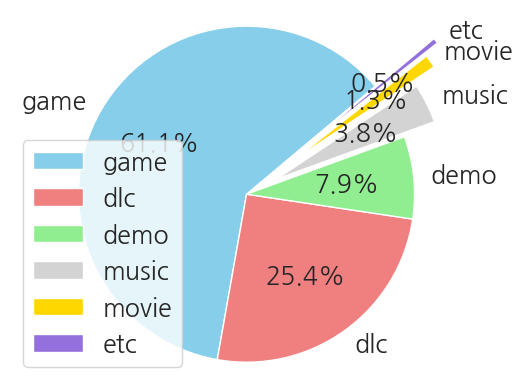

In [17]:
type_counts = SteamTypeDF['type'].value_counts()
labels = type_counts.index.tolist()
sizes = type_counts.values

total_size = sum(sizes)
small_indices = sizes / total_size < 1 / 100

resize_list = list()
reindex_list = list()

background_color = 'white'
fig, ax = plt.subplots()
fig.patch.set_facecolor(background_color)

# 라벨 변경
for i in range(len(labels)):
    if small_indices[i]:
        reindex_list.append('etc')
        resize_list.append(sum(sizes[i:]))
        break
    else:
        reindex_list.append(labels[i])
        resize_list.append(sizes[i])


ax.pie(resize_list, labels=reindex_list, autopct='%1.1f%%', startangle=40, explode=[0, 0, 0, 0.2, 0.35, 0.45], colors=['#87CEEB','#F08080','#90EE90','#D3D3D3','#FFD700','#9370DB'])
ax.axis('equal')
plt.legend(reindex_list)
plt.show()

In [18]:
SteamGameInfoDF = pd.read_csv('SteamGameInfoDF.csv', encoding='utf-8')
SteamGameInfoDF.drop(columns=['Unnamed: 0'], inplace=True)
SteamGameInfoDF

,appid,is_free,recommendations,release_date,release_status,score,price,age
0,2621440,False,"<h2 class=""bb_tag"">전투</h2>끝없는 전투와 도전의 세계에 빠져보세...",출시 예정 게임,True,-1,0,0
1,1835010,False,Blockies VR is a single player action-puzzle g...,출시 예정 게임,True,-1,0,0
2,1048580,False,"<img src=""https://cdn.akamai.steamstatic.com/s...",2020년 12월 16일,False,-1,"₩ 15,370",0
3,262150,False,"<h1>Prepaid Debit Cards</h1><p><a href=""https:...",2014년 3월 3일,False,-1,"₩ 3,350",0
4,1572870,False,"<h2 class=""bb_tag"">Pathfinder RPG - Shattered ...",2021년 5월 25일,False,-1,"₩ 20,500",0
...,...,...,...,...,...,...,...,...
112168,1369980,False,<h1>Try Abyss The Forgetten Past For Free</h1>...,2021년 1월 29일,False,-1,"₩ 4,400",0
112169,1894265,False,The Season Town Northern Rail Road (STNRR) is ...,2022년 5월 30일,False,-1,"₩ 31,000",0
112170,1894266,False,This stunning train has been upgraded to give ...,2022년 5월 30일,False,-1,"₩ 18,500",0
112171,1894267,False,This session lets you jump straight in and dri...,2022년 5월 30일,False,-1,"₩ 15,500",0


In [19]:
SteamGameCateDF = pd.read_csv('SteamGameCateDF.csv', encoding='utf-8')
SteamGameCateDF.drop(columns=['Unnamed: 0'], inplace=True)
SteamGameCateDF

,appid,categori
0,2621440,싱글 플레이어
1,1835010,싱글 플레이어
2,1835010,추적되는 컨트롤러 지원
3,1835010,VR 전용
4,1048580,싱글 플레이어
...,...,...
436484,1107840,다운로드 가능한 콘텐츠
436485,1107840,Steam 도전 과제
436486,1107840,컨트롤러 완벽 지원
436487,1107840,Steam 트레이딩 카드


In [20]:
dol = pd.read_csv('라벨링작업후/도타리뷰.csv', encoding='utf-8')
dol[['review','timestamp_created','voted_up','label']]

,review,timestamp_created,voted_up,label
0,사회부적응자들이나 하는게임,1674556305,True,0
1,4102시간 다른일 했으면 어땠을까요? 후회뿐이네요,1683121715,False,0
2,게임은 비추 누르고 5000시간하는 네놈들도 제정신은 아니야..,1695869380,False,0
3,평생 이거나 해,1672718531,True,1
4,롤의 어머니,1677940450,True,1
...,...,...,...,...
132,롤만아니였으면 우리나라가 다잡아먹었을 것이고 스팀이 초딩 서식지가 됐을뻔한게임,1488064889,True,1
133,오토체스가 그렇게 재밌나요?,1551587598,True,1
134,쩜,1415615882,True,2
135,인생 살다가 삶에 주어진 작업이 즐겁지 않을 때 켜라.\n피노이든 중국새끼들이든 슬...,1618770747,True,0


([<matplotlib.patches.Wedge at 0x288c0f070>,
 [Text(-1.0993493307119508, 0.03782920912715409, 'Positive'),
  Text(1.0878032680567093, -0.16335253290091123, 'negative'),
  Text(0.1601677893941254, 1.390807779400374, '-')],
 [Text(-0.5996450894792459, 0.020634114069356776, '48.9%'),
  Text(0.5933472371218413, -0.08910138158231522, '47.4%'),
  Text(0.10296500746765204, 0.8940907153288118, '3.6%')])

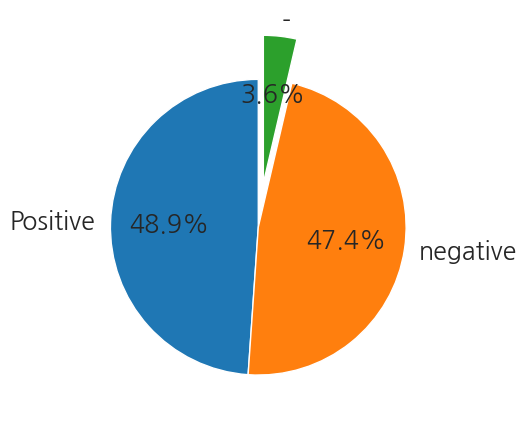

In [21]:
sizes =dol['label'].value_counts().values
plt.pie(sizes, labels=['Positive','negative','-'], autopct='%1.1f%%', startangle=90, explode=[0,0,0.3])

<BarContainer object of 3 artists>

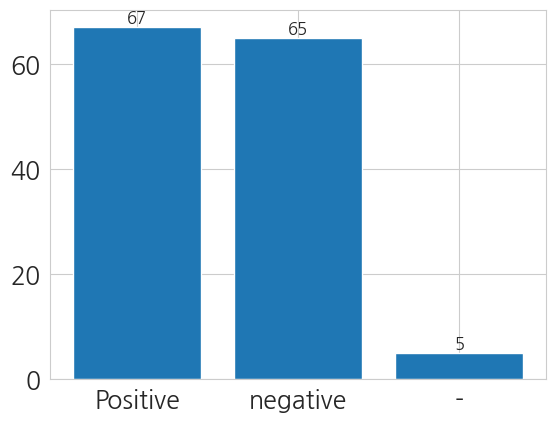

In [22]:
labels = ['Positive','negative','-']
for i in range(len(labels)):
    height = sizes[i]
    plt.text(labels[i], height + 0.25, sizes[i], ha='center', va='bottom', size = 12)
plt.bar(height=sizes, x=labels)

In [23]:
dol[['review','timestamp_created','voted_up','label']][dol['label']==2]

,review,timestamp_created,voted_up,label
22,.,1700858088,True,2
27,.,1689742632,True,2
88,"我爱北京天安门/(나는 베이징의 천안문을 사랑해)\n""⣿⣿⣿⣿⣿⠟⠋⠄⠄⠄⠄⠄⠄⠄⢁⠈⢻...",1647265084,True,2
99,○ キミを れっつ・はぶ・ふぁん♪ ○ ○ イントロダクション ○ [ur...,1624619331,True,2
134,쩜,1415615882,True,2


In [24]:
ell = pd.read_csv('라벨링작업후/엘등린리뷰.csv', encoding='utf-8')
ell[['review','timestamp_created','voted_up','label']]

,review,timestamp_created,voted_up,label
0,이새끼들아 사니까 할인을 해?,1696578560,True,0
1,DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘DLC내줘D...,1675852668,True,1
2,사랑받았기에 사랑한 것이 아니다.\n그는 그저 사랑했던 것이다.\n-트루킹 모르고트-,1673286762,True,1
3,알겠는가? 미켈라의 칼날 말레니아를.\n알겠는가? 미켈라의 칼날 말레니아를.\n알겠...,1687313367,True,1
4,밥 처먹을때도 엇박으로 먹을새끼들,1677422749,True,0
...,...,...,...,...
550,당신은 새로운 이세계에 왔습니다\n이제 이쁜 npc들이 당신주위를 둘러싸 용사님 세...,1656766862,True,1
551,알겠는가? 미켈라의 칼날 말레니아를 알겠는가? 미켈라의 칼날 말레니아를 알겠는가? ...,1661274249,True,1
552,말라리아 모기 씹새끼야 제발 피흡하지말고 돌진하지말고 뒤져라 씨발,1647867026,True,0
553,확실히 엘든링을 사고 나서 내 인생이 달라졌다.\n\n\n원래는 고딩때 일진 눈도 ...,1645869447,True,1


([<matplotlib.patches.Wedge at 0x288cf5220>,
 [Text(-0.9025528251923514, -0.6288071228423745, 'Positive'),
  Text(0.9096136025129795, 0.6185491848861815, 'negative'),
  Text(0.015849171042339523, 1.3999102841886943, '-')],
 [Text(-0.4923015410140098, -0.3429857033685679, '69.4%'),
  Text(0.49615287409798875, 0.3373904644833717, '30.3%'),
  Text(0.010188752812932548, 0.8999423255498749, '0.4%')])

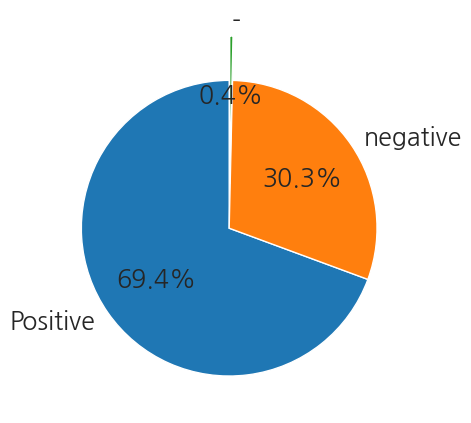

In [25]:
sizes =ell['label'].value_counts().values
plt.pie(sizes, labels=['Positive','negative','-'], autopct='%1.1f%%', startangle=90, explode=[0,0,0.3])

<BarContainer object of 3 artists>

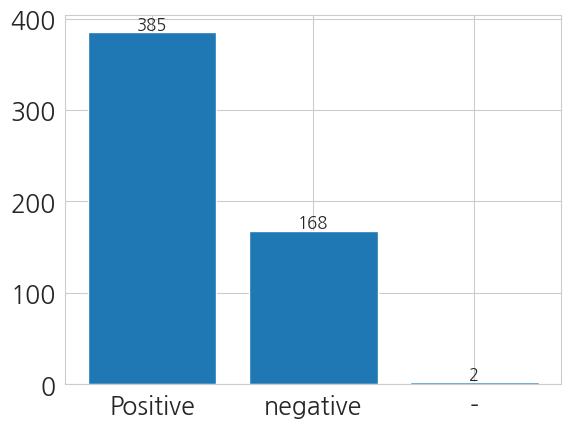

In [26]:
labels = ['Positive','negative','-']
for i in range(len(labels)):
    height = sizes[i]
    plt.text(labels[i], height + 0.25, sizes[i], ha='center', va='bottom', size = 12)
plt.bar(height=sizes, x=labels)

In [27]:
ell[['review','timestamp_created','voted_up','label']][ell['label']==2]


,review,timestamp_created,voted_up,label
181,.,1692877074,True,2
347,ㅤ,1689507218,True,2


In [28]:
cal = pd.read_csv('라벨링작업후/카스2리뷰.csv', encoding='utf-8')
cal[['review','timestamp_created','voted_up','label']]

,review,timestamp_created,voted_up,label
0,CS2가 나왔다는것은 CS3는 없다는 뜻입니다.,1695872973,True,0.0
1,군대간 사이에 짜장새끼들이 내 1130시간을 무로 만들었다 ㅅ발새끼들\n⣿⣿⣿⣿⣿⠟...,1694548982,True,0.0
2,Those idiotic Chinese bastards speak Chinese a...,1695913006,True,0.0
3,장점 : 전세계 플레이어들과 전투를 진행할 수 있다\n단점 : 전세계 병신들과 전투...,1695791847,True,1.0
4,뭔가 똑같은 국밥집인데\n가게 리모델링만 하고\n메뉴판은 그대로인 느낌,1695890027,True,0.0
...,...,...,...,...
433,"참신한 아이디어와 시도, 유저들과의 재치있는 소통으로 게임을 만들던 개발사 '밸브'...",1544429248,False,0.0
434,'그것들'만 없으면 참 좋은 게임입니다.\n\nFPS에는 꼭 있는 '그것들'\n,1642431758,True,1.0
435,글로벌 오펜시브입니다.\n\n이 게임은 카운터 스트라이크 1.6을 즐기던 노인들만 ...,1350808631,True,1.0
436,초반엔 정조준도 없고 조준한대로 맞지도 않아서 별로 재미가 없었으나\n플레이하면서 ...,1423565675,True,1.0


([<matplotlib.patches.Wedge at 0x288ec3cd0>,
 [Text(-1.0807528952987917, -0.20487356906950996, 'Positive'),
  Text(1.0835930101002984, 0.1892780717932602, 'negative'),
  Text(0.02017482212266128, 1.399854626935354, '-')],
 [Text(-0.5895015792538862, -0.11174921949245996, '56.0%'),
  Text(0.591050732781981, 0.10324258461450556, '43.6%'),
  Text(0.012969528507425106, 0.8999065458870132, '0.5%')])

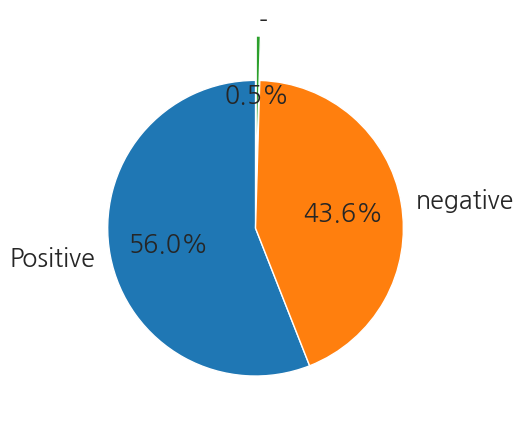

In [29]:
sizes =cal['label'].value_counts().values
plt.pie(sizes, labels=['Positive','negative','-'], autopct='%1.1f%%', startangle=90, explode=[0,0,0.3])

<BarContainer object of 3 artists>

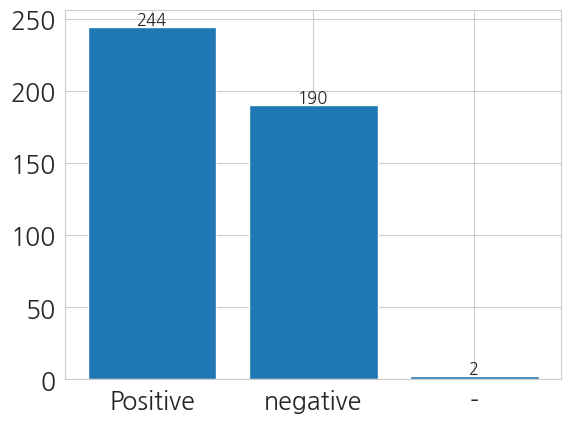

In [30]:
labels = ['Positive','negative','-']
for i in range(len(labels)):
    height = sizes[i]
    plt.text(labels[i], height + 0.25, sizes[i], ha='center', va='bottom', size = 12)
plt.bar(height=sizes, x=labels)

In [31]:
cal[['review','timestamp_created','voted_up','label']][cal['label']==2]

,review,timestamp_created,voted_up,label
122,.,1700993984,True,2.0
275,.,1696183741,False,2.0


In [32]:
dodrop = dol.drop(dol[dol['label'] == 2].index)
eldrop = ell.drop(ell[ell['label'] == 2].index)
cadrop =cal.drop(cal[cal['label'] == 2].index)
print(f'도타리뷰 데이터 \t | 삭제전 개수: {len(dodrop.index)} 삭제후 개수: {len(dol.index)}')
print(f'엘든링리뷰 데이터 \t | 삭제전 개수: {len(eldrop.index)} 삭제후 개수: {len(ell.index)}')
print(f'카스2리뷰 데이터 \t | 삭제전 개수: {len(cadrop.index)} 삭제후 개수: {len(cal.index)}')

도타리뷰 데이터 	 | 삭제전 개수: 132 삭제후 개수: 137
엘든링리뷰 데이터 	 | 삭제전 개수: 553 삭제후 개수: 555
카스2리뷰 데이터 	 | 삭제전 개수: 436 삭제후 개수: 438


In [33]:
print(do.isnull().sum())
print("="*30)
print(el.isnull().sum())
print("="*30)
print(ca.isnull().sum())

Unnamed: 0                          0
recommendationid                    0
language                            0
review                              0
timestamp_created                   0
timestamp_updated                   0
voted_up                            0
votes_up                            0
votes_funny                         0
weighted_vote_score                 0
comment_count                       0
steam_purchase                      0
received_for_free                   0
written_during_early_access         0
hidden_in_steam_china               0
steam_china_location              137
author.steamid                      0
author.num_games_owned              0
author.num_reviews                  0
author.playtime_forever             0
author.playtime_last_two_weeks      0
author.playtime_at_review           0
author.last_played                  0
dtype: int64
Unnamed: 0                          0
recommendationid                    0
language                            0

In [34]:
import re

In [35]:
dodrop['review'] = dodrop['review'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
dodrop['review'] = dodrop['review'].apply(lambda x: None if len(str(x).strip())<=1 else x )
dodrop[dodrop['review'].isnull()==True]

,Column1,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
20,20,137066488,koreana,None,1682100264,1682100264,False,3,0,0.526851,...,True,NaN,7.656120e+16,555,34,35308,0,35303,1693718414,0
23,23,150153697,koreana,None,1700026865,1700026865,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,1,2306,0,2306,1607091160,1
24,24,148895500,koreana,None,1698306028,1698306028,True,1,0,0.523810,...,True,NaN,7.656120e+16,2,2,37433,401,36667,1700821562,1
26,26,144163961,koreana,None,1692008474,1692008474,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,4,4110,995,1650,1701105719,0
29,29,127414019,koreana,None,1669655596,1669655596,False,1,0,0.523810,...,True,NaN,7.656120e+16,0,1,1423,0,1423,1669507431,0
31,31,127583344,koreana,None,1669748673,1669748673,True,1,0,0.521739,...,True,NaN,7.656120e+16,110,4,48996,39,30507,1701089856,0
126,126,74384021,koreana,None,1597552307,1597552307,True,9,2,0.643468,...,False,NaN,7.656120e+16,0,1,965179,8294,587277,1701148000,0


In [36]:
dodrop.drop(columns='Column1', inplace=True)
dodrop.drop(index=dodrop[dodrop['review'].isnull()==True].index,inplace=True)
dodrop

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
0,131454388,koreana,사회부적응자들이나 하는게임,1674556305,1674556305,True,66,49,0.825942,8,...,True,NaN,7.656120e+16,0,6,899554,2958,842370,1701093124,0
1,137731042,koreana,시간 다른일 했으면 어땠을까요 후회뿐이네요,1683121715,1683121715,False,15,4,0.700245,0,...,True,NaN,7.656120e+16,0,1,260777,1,246136,1700393452,0
2,147176677,koreana,게임은 비추 누르고 시간하는 네놈들도 제정신은 아니야,1695869380,1695869380,False,13,6,0.676641,0,...,True,NaN,7.656120e+16,70,7,48630,0,47890,1699427903,0
3,129998532,koreana,평생 이거나 해,1672718531,1672718531,True,19,7,0.661004,0,...,True,NaN,7.656120e+16,0,2,459275,383,424523,1700834596,1
4,134049649,koreana,롤의 어머니,1677940450,1677940450,True,12,1,0.627084,0,...,True,NaN,7.656120e+16,0,1,97467,221,81336,1700399033,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,63521439,koreana,이 게임은 대한민국 육군의 현역 복무중인 일병 황리뉴가 평가했을 때 매우 훌륭한 게...,1581738300,1581738300,True,22,5,0.640430,5,...,False,NaN,7.656120e+16,23,1,862367,0,789551,1699195125,1
132,30180723,koreana,롤만아니였으면 우리나라가 다잡아먹었을 것이고 스팀이 초딩 서식지가 됐을뻔한게임,1488064889,1488064889,True,14,1,0.639235,4,...,False,NaN,7.656120e+16,120,35,957,0,957,1455951597,1
133,49328584,koreana,오토체스가 그렇게 재밌나요,1551587598,1551587598,True,12,0,0.636813,0,...,False,NaN,7.656120e+16,0,4,24590,0,11155,1561792059,1
135,90537785,koreana,인생 살다가 삶에 주어진 작업이 즐겁지 않을 때 켜라 피노이든 중국새끼들이든 슬라브...,1618770747,1651550438,True,9,2,0.636287,0,...,False,NaN,7.656120e+16,0,2,100899,1,60301,1700569036,0


In [37]:
eldrop['review'] = eldrop['review'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
eldrop['review'] = eldrop['review'].apply(lambda x: None if len(x.strip())==0 else x )
eldrop[eldrop['review'].isnull()==True]

,Column1,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
74,74,137265709,koreana,None,1682413153,1682433288,True,6,0,0.584608,...,True,NaN,7.656120e+16,130,33,10750,0,9264,1682722403,0
79,79,133108522,koreana,None,1676734908,1676734908,True,6,1,0.571345,...,True,NaN,7.656120e+16,92,12,7339,0,7108,1678451949,1
124,124,150225193,koreana,None,1700145635,1700145635,True,6,1,0.528282,...,True,NaN,7.656120e+16,0,2,4666,4174,1574,1701003090,1
133,133,151044638,koreana,None,1700666127,1700666127,True,1,0,0.523810,...,True,NaN,7.656120e+16,169,53,4986,1010,4986,1700665849,0
162,162,147911558,koreana,None,1696834193,1696834193,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,1,5573,95,4116,1700107244,1
195,195,142939570,koreana,None,1690530323,1690530404,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,4,4698,0,4673,1690978944,1
198,198,142597074,koreana,None,1690048727,1690822328,True,1,0,0.523810,...,True,NaN,7.656120e+16,23,1,11534,0,6209,1693742175,1
231,231,136027611,koreana,None,1680533963,1680533963,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,1,6163,0,4221,1682656487,1
236,236,135250414,koreana,None,1679595051,1679595051,True,1,0,0.523810,...,True,NaN,7.656120e+16,285,8,24151,0,19864,1684235592,1
237,237,135103262,koreana,None,1679409814,1679409814,True,1,0,0.523810,...,True,NaN,7.656120e+16,0,2,14577,0,969,1697980871,1


In [38]:
eldrop.drop(columns='Column1', inplace=True)
eldrop.drop(index=eldrop[eldrop['review'].isnull()==True].index,inplace=True)
eldrop

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
0,147726617,koreana,이새끼들아 사니까 할인을 해,1696578560,1696578560,True,187,148,0.931886,5,...,True,NaN,7.656120e+16,0,3,4344,0,838,1698749980,0
1,132414832,koreana,내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 내줘 ...,1675852668,1675852668,True,118,10,0.888463,8,...,True,NaN,7.656120e+16,51,2,7835,0,6403,1683907287,1
2,130517026,koreana,사랑받았기에 사랑한 것이 아니다 그는 그저 사랑했던 것이다 트루킹 모르고트,1673286762,1673349209,True,112,5,0.868580,2,...,True,NaN,7.656120e+16,292,28,2657,0,2657,1673286617,1
3,140419305,koreana,알겠는가 미켈라의 칼날 말레니아를 알겠는가 미켈라의 칼날 말레니아를 알겠는가 ...,1687313367,1687313367,True,108,51,0.868188,1,...,True,NaN,7.656120e+16,51,6,8338,0,4019,1698847554,1
4,133670459,koreana,밥 처먹을때도 엇박으로 먹을새끼들,1677422749,1677422749,True,66,64,0.865157,2,...,True,NaN,7.656120e+16,0,202,3973,0,358,1697449317,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,118060680,koreana,당신은 새로운 이세계에 왔습니다 이제 이쁜 들이 당신주위를 둘러싸 용사님 세계를 ...,1656766862,1656766919,True,33,31,0.733317,0,...,False,NaN,7.656120e+16,0,22,4888,0,4888,1648894426,1
551,121122114,koreana,알겠는가 미켈라의 칼날 말레니아를 알겠는가 미켈라의 칼날 말레니아를 알겠는가 ...,1661274249,1661274249,True,38,28,0.731779,0,...,False,NaN,7.656120e+16,0,1,8845,0,4465,1697371430,1
552,112591836,koreana,말라리아 모기 씹새끼야 제발 피흡하지말고 돌진하지말고 뒤져라 씨발,1647867026,1647867026,True,27,16,0.730779,0,...,False,NaN,7.656120e+16,0,77,17824,0,6140,1696849631,0
553,111059993,koreana,확실히 엘든링을 사고 나서 내 인생이 달라졌다 원래는 고딩때 일진 눈도 못마주치고 ...,1645869447,1645869447,True,215,363,0.729797,53,...,False,NaN,7.656120e+16,1543,61,3201,0,44,1647186490,1


In [39]:
cadrop['review'] = cadrop['review'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
cadrop['review'] = cadrop['review'].apply(lambda x: None if len(x.strip())==0 else x )
cadrop[cadrop['review'].isnull()==True]

,Column1,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
6,6,149449125,koreana,None,1699027399,1699027399,True,64,3,0.853346,...,True,NaN,7.656120e+16,225,20,6547,0,3753,1699499344,0.0
9,9,129696608,koreana,None,1672412579,1672412579,True,116,34,0.835500,...,True,NaN,7.656120e+16,0,6,3492,0,818,1699043565,0.0
12,12,137321163,koreana,None,1682514431,1682514431,True,86,32,0.803722,...,True,NaN,7.656120e+16,24,1,3317,0,676,1692721079,0.0
24,24,138471650,koreana,None,1684389746,1684389746,False,29,8,0.715358,...,True,NaN,7.656120e+16,70,6,25541,99,17512,1700476651,0.0
28,28,150104483,koreana,None,1699950943,1699950943,True,20,0,0.702631,...,True,NaN,7.656120e+16,0,2,7113,2223,4867,1701091307,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,370,111285088,koreana,None,1646112699,1646112699,True,86,32,0.855983,...,False,NaN,7.656120e+16,74,2,289,0,288,1646140173,0.0
390,390,114876406,koreana,None,1651570574,1651570574,True,57,24,0.803634,...,False,NaN,7.656120e+16,0,1,12669,0,4780,1699102929,0.0
396,396,43588187,koreana,None,1531845372,1575385340,True,45,10,0.787891,...,False,NaN,7.656120e+16,24,4,611812,322,1920,1700926641,0.0
397,397,105624574,koreana,None,1639212151,1639212151,False,101,26,0.787012,...,False,NaN,7.656120e+16,0,1,1152,0,886,1657620123,0.0


In [40]:
cadrop.drop(columns='Column1', inplace=True)
cadrop.drop(index=cadrop[cadrop['review'].isnull()==True].index,inplace=True)
cadrop

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,hidden_in_steam_china,steam_china_location,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,label
0,147179421,koreana,가 나왔다는것은 는 없다는 뜻입니다,1695872973,1695872973,True,369,158,0.942205,0,...,True,NaN,7.656120e+16,0,41,18123,637,14701,1700927307,0.0
1,146187005,koreana,군대간 사이에 짜장새끼들이 내 시간을 무로 만들었다 ㅅ발새끼들,1694548982,1694548982,True,459,240,0.937254,0,...,True,NaN,7.656120e+16,0,15,67781,0,67780,1699273252,0.0
2,147213315,koreana,중국 새끼들이 영어를 안쓰고 병신같...,1695913006,1695913006,True,114,18,0.872324,0,...,True,NaN,7.656120e+16,0,8,3470,86,1129,1700845061,0.0
3,147108748,koreana,장점 전세계 플레이어들과 전투를 진행할 수 있다 단점 전세계 병신들과 전투를...,1695791847,1695791847,True,163,60,0.871487,0,...,True,NaN,7.656120e+16,0,6,32607,1761,26030,1701159491,1.0
4,147191443,koreana,뭔가 똑같은 국밥집인데 가게 리모델링만 하고 메뉴판은 그대로인 느낌,1695890027,1695890027,True,137,23,0.870188,3,...,True,NaN,7.656120e+16,92,10,1759,0,1048,1699082046,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,47433805,koreana,참신한 아이디어와 시도 유저들과의 재치있는 소통으로 게임을 만들던 개발사 밸브 ...,1544429248,1544429248,False,29,0,0.737590,0,...,False,NaN,7.656120e+16,0,7,13358,0,5128,1696063826,0.0
434,108208488,koreana,그것들 만 없으면 참 좋은 게임입니다 에는 꼭 있는 그것들,1642431758,1642431758,True,25,0,0.736484,0,...,False,NaN,7.656120e+16,0,40,8367,0,8367,1641970428,1.0
435,4388240,koreana,글로벌 오펜시브입니다 이 게임은 카운터 스트라이크 을 즐기던 노인들만 좋아한다는 ...,1350808631,1350808631,True,67,115,0.736434,2,...,False,NaN,7.656120e+16,658,296,2137,0,1972,1376537438,1.0
436,14415325,koreana,초반엔 정조준도 없고 조준한대로 맞지도 않아서 별로 재미가 없었으나 플레이하면서 감...,1423565675,1452929727,True,46,3,0.735870,0,...,False,NaN,7.656120e+16,354,35,43108,0,34444,1696229046,1.0


In [41]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords.extend(['게임','정도','진짜','도타','카스','처음','글옵'])
stopwords[:]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해'],
 ['을'],
 ['를'],
 ['에'],
 ['의'],
 ['가'],
 ['으로'],
 ['로'],
 ['에게'],
 ['뿐이다'],
 ['의거하여'],
 ['근거하여'],
 ['입각하여'],
 ['기준으로'],
 ['예하면'],
 ['예를 들면'],
 ['예를 들자면'],
 ['저'],
 ['소인'],
 ['소생'],
 ['저희'],
 ['지말고'],
 ['하지마'],
 ['하지마라'],
 ['다른'],
 ['물론'],
 ['또한'],
 ['그리고'],
 ['비길수 없다'],
 ['해서는 안된다'],
 ['뿐만 아니라'],
 ['만이 아니다'],
 ['만은 아니다'],
 ['막론하고'],
 ['관계없이'],
 ['그치지 않다'],
 ['그러나'],
 ['그런데'],
 ['하지만'],
 ['든간에'],
 ['논하지 않다'],
 ['따지지 않다'],
 ['설사'],
 ['비록'],
 ['더라도'],
 ['아니면'],
 ['만 못하다'],
 ['하는 편이 낫다'],
 ['불문하고'],
 ['향하여'],
 ['향해서'],
 ['향하다'],
 ['쪽으로'],
 ['틈타'],
 ['이용하여'],
 ['타다'],
 ['오르다'],
 ['제외하고'],
 ['이 외에'],
 ['이 밖에'],
 ['하여야'],
 ['비로소'],
 ['한다면 몰라도'],
 ['외에도'],
 ['이곳'],
 ['여기'],
 ['부터'],
 ['기점으로'],
 ['따라서'],
 ['할 생각이다'],
 ['하려고하다'],
 ['이리하여'],
 ['그리하여'],
 ['그렇게 함으로써'],
 ['하지만'],
 ['일때'],
 ['할때'],
 ['앞에서'],
 ['중에서'],
 ['보는데서'],
 ['으로써'],
 ['로써'],
 ['까지'],
 ['해야한다'],
 ['일것이다'],
 ['반드시'],
 ['할줄알다'],
 ['할수있다'],
 [

In [42]:
from konlpy.tag import Okt
from collections import Counter

okt = Okt()
def frequency_text(df):
    corpus = "".join(df['review'].tolist())
    nouns = okt.nouns(corpus)
    counter = Counter(nouns)
    #available_counter = Counter({x: counter[x] for x in counter if len(x) > 1 or x =='핵'})
    available_counter = Counter({x: counter[x] for x in counter if x not in stopwords})
    print(available_counter.most_common(10))
    return counter, available_counter

dota_frequency = frequency_text(dodrop)
eldenring_frequency = frequency_text(eldrop)
cs2_frequency = frequency_text(cadrop)

[('영웅', 43), ('수', 39), ('것', 37), ('롤', 36), ('시간', 31), ('이', 29), ('사람', 22), ('팀', 20), ('플레이', 19), ('그', 18)]
[('말레', 416), ('켈라', 404), ('이', 386), ('니아', 327), ('칼날', 312), ('도전', 256), ('죽음', 213), ('너머', 205), ('강적', 195), ('링', 179)]
[('사랑', 88), ('핵', 53), ('것', 37), ('발', 35), ('이', 35), ('나', 33), ('유저', 32), ('중국인', 31), ('겜', 31), ('새끼', 28)]


In [43]:
print(f"dota: {dota_frequency[1].most_common(20)}")
print(f"elden: {eldenring_frequency[1].most_common(20)}")
print(f"cs2: {cs2_frequency[1].most_common(20)}")

dota: [('영웅', 43), ('수', 39), ('것', 37), ('롤', 36), ('시간', 31), ('이', 29), ('사람', 22), ('팀', 20), ('플레이', 19), ('그', 18), ('체스', 16), ('하나', 15), ('때', 15), ('매치', 14), ('적', 14), ('안', 14), ('시스템', 14), ('아이템', 13), ('오토', 12), ('플레이어', 12)]
elden: [('말레', 416), ('켈라', 404), ('이', 386), ('니아', 327), ('칼날', 312), ('도전', 256), ('죽음', 213), ('너머', 205), ('강적', 195), ('링', 179), ('것', 175), ('보스', 173), ('소울', 165), ('재', 150), ('엘', 143), ('수', 138), ('제발', 112), ('플레이', 97), ('시간', 97), ('오브', 94)]
cs2: [('사랑', 88), ('핵', 53), ('것', 37), ('발', 35), ('이', 35), ('나', 33), ('유저', 32), ('중국인', 31), ('겜', 31), ('새끼', 28), ('말', 28), ('내', 27), ('사람', 27), ('수', 25), ('개', 24), ('좀', 23), ('시작', 22), ('시발', 22), ('짱깨', 22), ('과제', 21)]


In [44]:
class Visualization:
    def __init__(self, wordList, filename, img):
        self.wordList = wordList
        self.wordDict = dict(wordList)  # list를 사전으로 변경
        self.filename = filename
        self.img = img
    def makeWordCloud(self): # 워드 클라우드
        a_color_file = self.img
        print(a_color_file)
        a_coloring = np.array(Image.open(a_color_file))
        wordcloud = WordCloud(mask=a_coloring, \
                              relative_scaling=0.2, background_color='lightyellow',
                              font_path='nanum-gothic/NanumGothic.ttf')
        print(self.wordDict)
        wordcloud = wordcloud.generate_from_frequencies(self.wordDict)

        plt.imshow(wordcloud)
        plt.axis('off')

        filename = f'시각/{self.filename}_wc.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(filename + ' 파일이 저장되었습니다.')
        plt.figure(figsize=(16, 8))
    # end def makeWordCloud(wordlist)

    def makeBarChart(self): # 막대 그래프 그리기
        barcount = 15  # 막대 개수 : 10개만 그리겠다.
        xlow, xhigh = - 0.5, barcount - 0.5

        result = self.wordList[:barcount]
        chartdata = []  # 차트 수치
        xdata = []  # 글씨
        mycolor = ['r', 'g', 'b', 'y', 'm', 'c', '#FFF0F0', '#CCFFBB', '#05CCFF', '#11CCFF']

        for idx in range(len(result)):
            chartdata.append(result[idx][1])
            xdata.append(result[idx][0])

            value = str(chartdata[idx]) + '건'  # 예시 : 60건
            plt.text(x=idx, y=chartdata[idx] - 5, s=value, fontsize=8, horizontalalignment='center')

        plt.xticks(range(barcount), xdata, rotation=45)
        plt.bar(range(barcount), chartdata, align='center', color=mycolor)

        plt.title('상위 ' + str(barcount) + '빈도수')
        plt.xlim([xlow, xhigh])
        plt.xlabel('주요 키워드')
        plt.ylabel('빈도수')
        filename = f'시각/{self.filename}_bar.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(filename + ' 파일이 저장되었습니다.')

def word_cloud(filename, frequency, img):
    komo = Komoran()
    wordlist = list()  # 튜플(단어, 빈도수)을 저장할 리스트

    for word, count in frequency.most_common(500) :
        # count는 빈도수를 의미하고, len(word)는 단어의 길이를 의미합니다.
        if (count >= 1 and len(word) >= 2) :
            wordlist.append((word, count))
    visual = Visualization(wordlist, filename, img)
    visual.makeWordCloud()
    visual.makeBarChart()

dota.png
{'영웅': 43, '시간': 31, '사람': 22, '플레이': 19, '체스': 16, '하나': 15, '매치': 14, '시스템': 14, '아이템': 13, '오토': 12, '플레이어': 12, '유저': 12, '한국': 12, '생각': 12, '장르': 12, '매우': 11, '행위': 11, '히오스': 10, '유즈맵': 10, '전략': 10, '경우': 10, '서포터': 10, '단점': 9, '서버': 9, '시작': 9, '다른': 9, '자신': 9, '요소': 9, '장점': 8, '스트레스': 8, '인생': 8, '때문': 8, '공격': 8, '와드': 8, '매칭': 8, '스팀': 7, '위해': 7, '상대': 7, '거나': 6, '문제점': 6, '장벽': 6, '재미': 6, '실력': 6, '진입': 6, '추천': 6, '업데이트': 6, '크립': 6, '특징': 6, '사용': 6, '대부분': 6, '다음': 6, '모든': 6, '구매': 6, '갱킹': 6, '프로게이머': 6, '낭비': 6, '뉴비': 6, '무료': 5, '망겜': 5, '당신': 5, '아군': 5, '최고': 5, '새끼': 5, '오브': 5, '패치': 5, '한판': 5, '역시': 5, '가장': 5, '수가': 5, '밸브': 5, '독보': 5, '역할': 5, '시야': 5, '기록': 5, '이상': 5, '사용자': 5, '상금': 5, '스킨': 5, '우리': 5, '평생': 4, '클라이언트': 4, '동안': 4, '캐릭터': 4, '한번': 4, '채팅': 4, '친구': 4, '이해': 4, '컨셉': 4, '기능': 4, '티배깅': 4, '게이머': 4, '조종': 4, '존재': 4, '또한': 4, '능력': 4, '오브젝트': 4, '가지': 4, '평가': 4, '실제': 4, '그래픽': 4, '규모': 4, '프로': 4, '캐리': 4, '명의': 4, '개인':

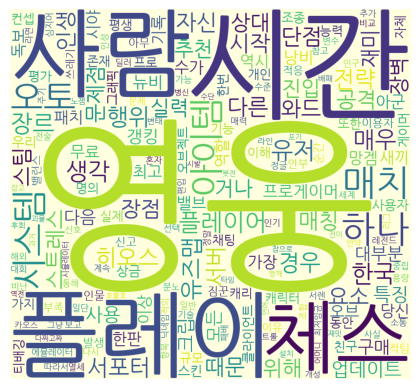

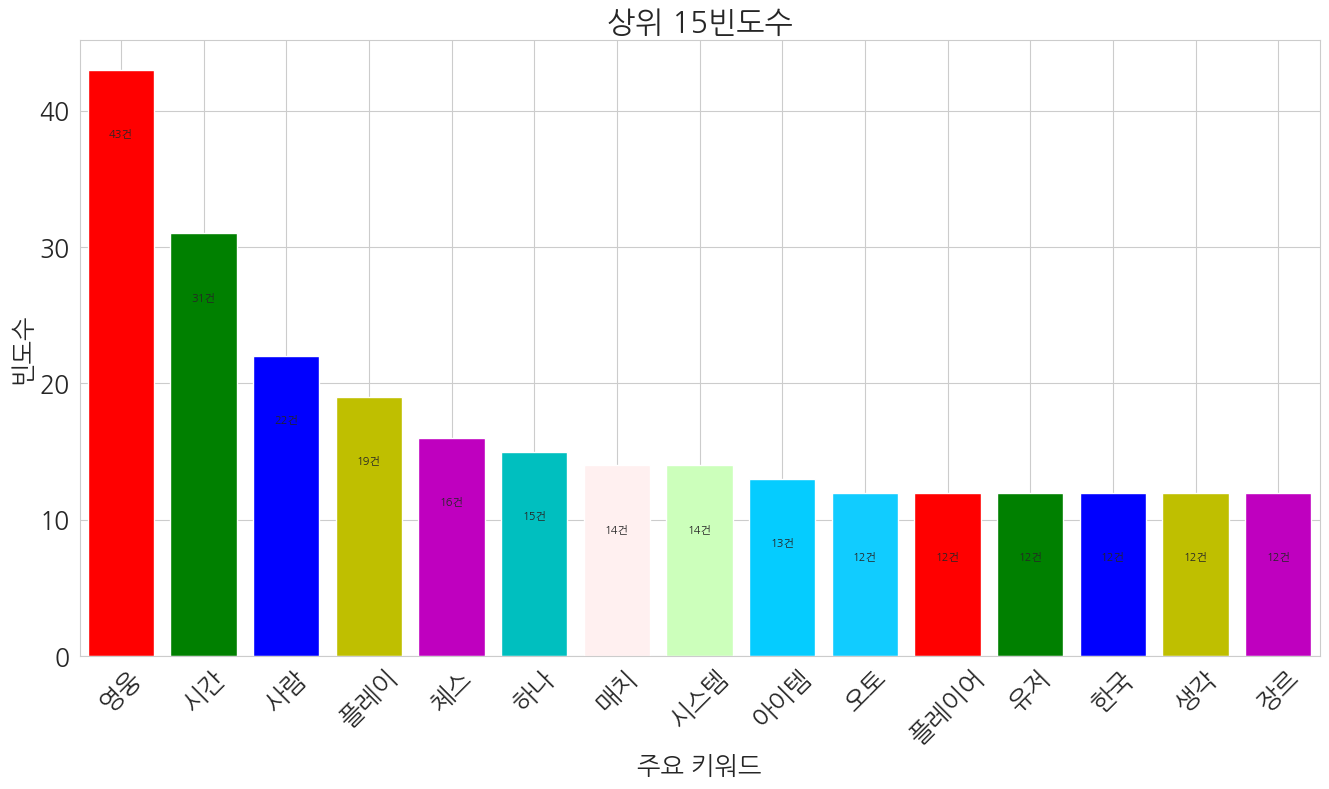

In [45]:
word_cloud("dota2_1",dota_frequency[1], "dota.png")

elden.jpeg
{'말레': 416, '켈라': 404, '니아': 327, '칼날': 312, '도전': 256, '죽음': 213, '너머': 205, '강적': 195, '보스': 173, '소울': 165, '제발': 112, '플레이': 97, '시간': 97, '오브': 94, '아이': 92, '블레이드': 91, '제나': 83, '다크': 77, '오픈월드': 76, '생각': 75, '프롬': 71, '투기': 70, '진행': 57, '거짓말쟁이': 56, '무기': 54, '스토리': 53, '사람': 49, '전작': 48, '회차': 47, '하나': 47, '난이도': 47, '공략': 46, '패턴': 44, '시리즈': 43, '정말': 41, '전투': 41, '느낌': 40, '모든': 38, '추천': 38, '엔딩': 36, '디자인': 36, '레벨': 36, '그냥': 35, '다른': 35, '재미': 35, '공격': 34, '가장': 31, '가드': 31, '보고': 30, '트리': 30, '방식': 29, '지역': 29, '선택': 29, '당신': 29, '때문': 28, '이크': 28, '시스템': 27, '초반': 27, '최적화': 27, '최고': 26, '마법': 26, '경우': 25, '단점': 24, '군대': 24, '발표': 24, '문제': 24, '존재': 23, '또한': 23, '부분': 23, '새끼': 22, '모험': 22, '평가': 22, '플레이어': 22, '시작': 22, '지금': 21, '마음': 21, '존나': 21, '던전': 21, '그래픽': 21, '방법': 21, '입문': 21, '우리': 20, '요소': 20, '이상': 20, '자유도': 20, '씨발': 19, '퀘스트': 19, '탐험': 19, '전회': 18, '개인': 18, '노가다': 18, '추가': 18, '기술': 17, '기트': 17, '해도': 17, '여러': 1

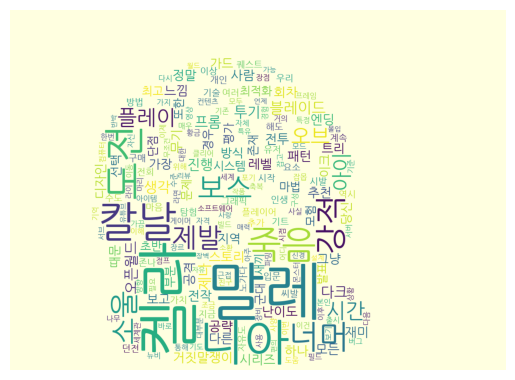

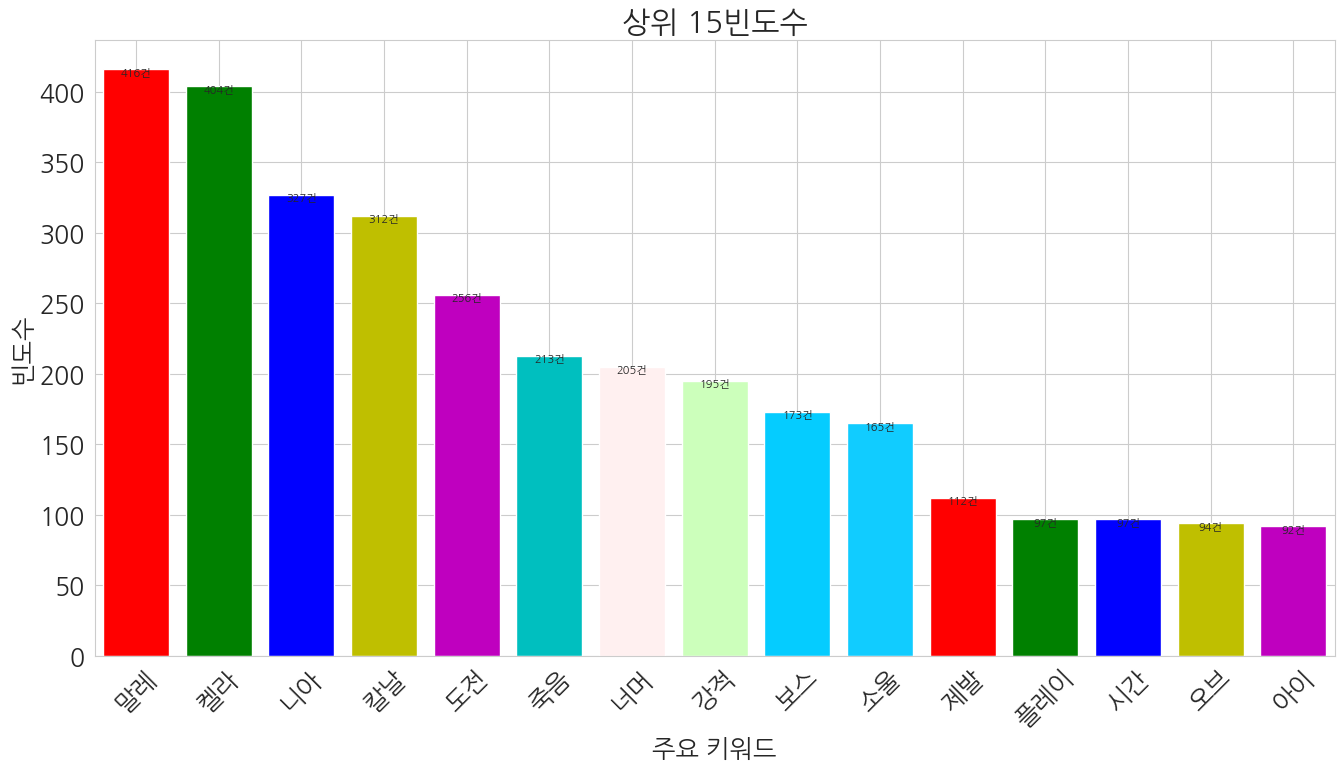

In [46]:
word_cloud("elden_1",eldenring_frequency[1], "elden.jpeg")

cs2.png
{'사랑': 88, '유저': 32, '중국인': 31, '새끼': 28, '사람': 27, '시작': 22, '시발': 22, '짱깨': 22, '과제': 21, '도전': 20, '존나': 19, '중국': 18, '생각': 16, '플레이': 16, '매칭': 15, '영어': 14, '글로벌': 14, '다시': 14, '정말': 14, '친구': 14, '시간': 13, '병신': 13, '그냥': 13, '상대': 12, '카운터': 12, '스트라이크': 12, '재미': 12, '하나': 11, '씨발': 11, '추천': 11, '매치': 11, '로란': 10, '실력': 10, '스팀': 10, '경쟁': 10, '스킨': 10, '수준': 10, '바로': 9, '한국인': 9, '뉴비': 8, '우리': 8, '핵좀': 8, '최고': 8, '역시': 8, '때문': 8, '러시안': 8, '일단': 8, '강퇴': 7, '시브': 7, '채팅': 7, '이제': 7, '머리': 7, '인물': 7, '이유': 7, '투표': 7, '해도': 7, '팀킬': 7, '세계': 7, '다른': 7, '중국어': 6, '차단': 6, '보고': 6, '제발': 6, '추억': 6, '조금': 6, '가장': 6, '러시아': 6, '러시아인': 6, '쓰레기': 6, '추방': 6, '밸런스': 6, '보이스': 6, '폭탄': 6, '프라임': 6, '문제': 6, '마이크': 6, '본인': 6, '당신': 6, '사설': 6, '진행': 5, '느낌': 5, '어디': 5, '근본': 5, '서버': 5, '어이': 5, '예전': 5, '갑자기': 5, '그것': 5, '사격': 5, '그래픽': 5, '승급': 5, '쥬얼': 5, '나라': 5, '평가': 5, '인생': 5, '구매': 5, '대부분': 5, '무료': 5, '트롤': 5, '사실': 5, '도박': 5, '서든': 5, '리볼버': 5, '뭔가':

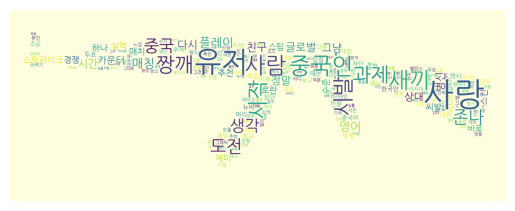

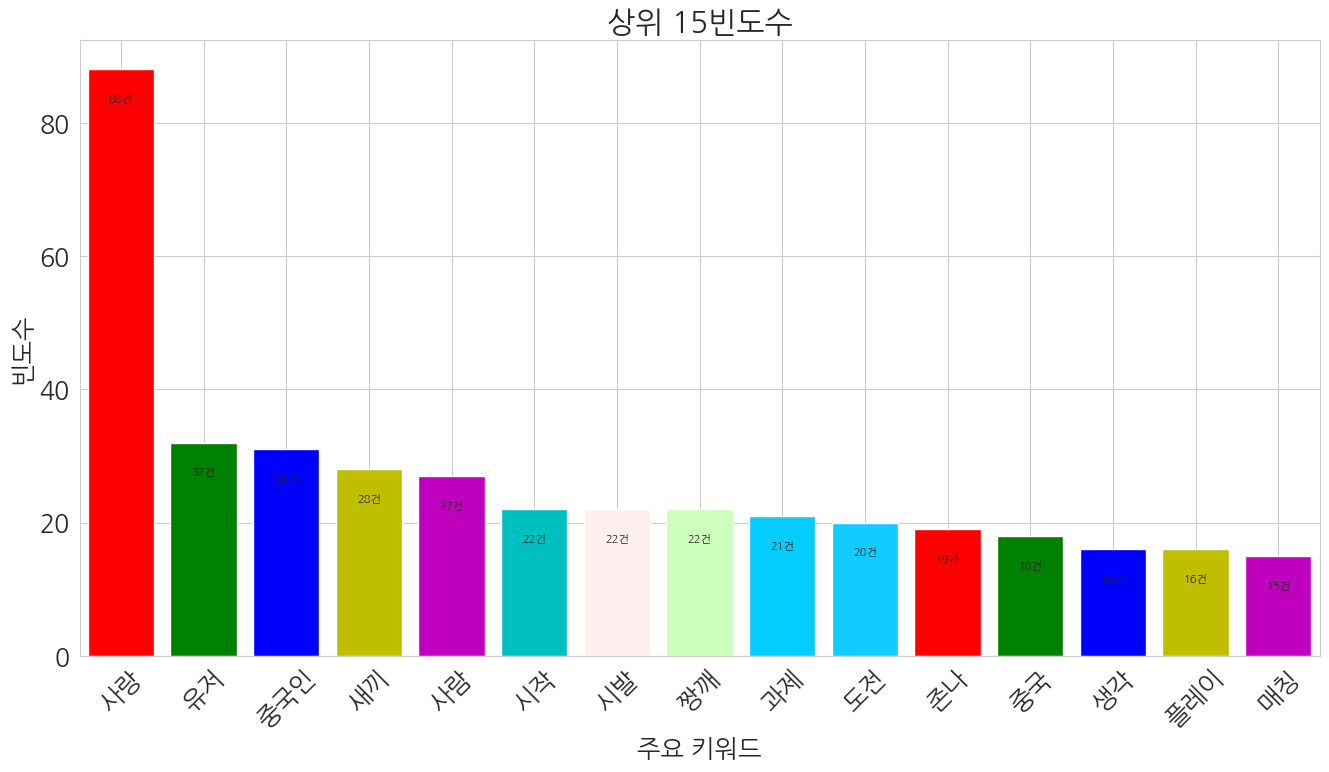

In [47]:
word_cloud("cs2_1",cs2_frequency[1], "cs2.png")

In [48]:
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def frequency_text_Bow(corpus):
    okt = Okt()
    #corpus = "".join(df['review'].tolist())
    nouns = okt.nouns(corpus)
    #available_counter = Counter({x: counter[x] for x in counter if len(x) > 1 or x =='핵'})
    available_counter = {x: x for x in nouns if x not in stopwords}
    return available_counter

vect_dota = CountVectorizer(tokenizer = lambda x: frequency_text_Bow(x))
dota_bow_vect = vect_dota.fit_transform(dodrop['review'].tolist())
dota_word_list = vect_dota.get_feature_names_out()
dota_count_list = dota_bow_vect.toarray().sum(axis=0)

vect_el = CountVectorizer(tokenizer = lambda x: frequency_text_Bow(x))
elden_bow_vect = vect_el.fit_transform(eldrop['review'].tolist())
elden_word_list = vect_el.get_feature_names_out()
elden_count_list = elden_bow_vect.toarray().sum(axis=0)

vect_cs2 = CountVectorizer(tokenizer = lambda x: frequency_text_Bow(x))
cs2_bow_vect = vect_cs2.fit_transform(cadrop['review'].tolist())
cs2_word_list = vect_cs2.get_feature_names_out()
cs2_count_list = cs2_bow_vect.toarray().sum(axis=0)

/Users/min/anaconda3/envs/BigDataStu/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [49]:
def sorted_word_count(word_list, count_list):
    word_count_dict = dict(zip(word_list, count_list))
    word_count_dict = sorted(word_count_dict.items(), key=lambda x:x[1], reverse=True)
    return word_count_dict

dota_word_count = sorted_word_count(dota_word_list, dota_count_list)
elden_word_count = sorted_word_count(elden_word_list, elden_count_list)
cs2_word_count = sorted_word_count(cs2_word_list, cs2_count_list)


In [50]:
class VisualizationBoW:
    def __init__(self, wordList, filename, img):
        self.wordList = wordList
        self.wordDict = dict(wordList)  # list를 사전으로 변경
        self.filename = filename
        self.img = img
    def makeWordCloud(self): # 워드 클라우드
        a_color_file = self.img
        print(a_color_file)
        a_coloring = np.array(Image.open(a_color_file))
        wordcloud = WordCloud(mask=a_coloring, \
                              relative_scaling=0.2, background_color='lightyellow',
                              font_path='nanum-gothic/NanumGothic.ttf')
        print(self.wordDict)
        wordcloud = wordcloud.generate_from_frequencies(self.wordDict)
        
        plt.imshow(wordcloud)
        plt.axis('off')

        filename = f'시각/{self.filename}_wc.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(filename + ' 파일이 저장되었습니다.')
        plt.figure(figsize=(16, 8))
    # end def makeWordCloud(wordlist)

    def makeBarChart(self): # 막대 그래프 그리기
        barcount = 15  # 막대 개수 : 10개만 그리겠다.
        xlow, xhigh = - 0.5, barcount - 0.5

        result = self.wordList[:barcount]
        chartdata = []  # 차트 수치
        xdata = []  # 글씨
        mycolor = ['r', 'g', 'b', 'y', 'm', 'c', '#FFF0F0', '#CCFFBB', '#05CCFF', '#11CCFF']

        for idx in range(len(result)):
            chartdata.append(result[idx][1])
            xdata.append(result[idx][0])

            value = str(chartdata[idx]) + '건'  # 예시 : 60건
            plt.text(x=idx, y=chartdata[idx] - 5, s=value, fontsize=8, horizontalalignment='center')

        plt.xticks(range(barcount), xdata, rotation=45)
        plt.bar(range(barcount), chartdata, align='center', color=mycolor)

        plt.title('상위 ' + str(barcount) + '빈도수')
        plt.xlim([xlow, xhigh])
        plt.xlabel('주요 키워드')
        plt.ylabel('빈도수')
        filename = f'시각/{self.filename}_bar.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(filename + ' 파일이 저장되었습니다.')
        
def word_cloud(filename, frequency, img):
    komo = Komoran()
    wordlist = list()  # 튜플(단어, 빈도수)을 저장할 리스트
    
    for word, count in frequency :
        # count는 빈도수를 의미하고, len(word)는 단어의 길이를 의미합니다.
        if (count >= 1 and len(word) >= 2) :
            wordlist.append((word, count))
    visual = VisualizationBoW(wordlist, filename, img)
    visual.makeWordCloud()
    visual.makeBarChart()


dota.png
{'시간': 19, '체스': 16, '오토': 15, '사람': 10, '플레이': 9, '인생': 8, '한국': 8, '생각': 6, '영웅': 6, '재미': 6, '하나': 6, '히오스': 6, '뉴비': 5, '다른': 5, '다음': 5, '망겜': 5, '매우': 5, '매치': 5, '모든': 5, '새끼': 5, '서버': 5, '시작': 5, '유저': 5, '자신': 5, '장벽': 5, '장점': 5, '거나': 4, '공격': 4, '낭비': 4, '단점': 4, '당신': 4, '때문': 4, '매칭': 4, '무료': 4, '밸브': 4, '스트레스': 4, '스팀': 4, '시스템': 4, '실제': 4, '아이템': 4, '요소': 4, '위해': 4, '자체': 4, '진입': 4, '채팅': 4, '평가': 4, '평생': 4, '한판': 4, '가능': 3, '가장': 3, '개성': 3, '그냥': 3, '그래픽': 3, '대부분': 3, '독보': 3, '동안': 3, '레전드': 3, '리그': 3, '매력': 3, '밸런스': 3, '보고': 3, '사실': 3, '상대': 3, '서렌': 3, '수가': 3, '순간': 3, '스킨': 3, '실력': 3, '쓰레기': 3, '아군': 3, '아무': 3, '역시': 3, '오브': 3, '용량': 3, '유즈맵': 3, '이상': 3, '이해': 3, '인물': 3, '장르': 3, '정말': 3, '조합': 3, '존재': 3, '최고': 3, '추가': 3, '추천': 3, '친구': 3, '캐릭터': 3, '크립': 3, '패치': 3, '플레이어': 3, '가지': 2, '개인': 2, '갱킹': 2, '거의': 2, '게이머': 2, '결정': 2, '경고': 2, '경우': 2, '계속': 2, '골드': 2, '과정': 2, '구매': 2, '국내': 2, '굳이': 2, '귀결': 2, '규모': 2, '그게': 2, '그대로': 

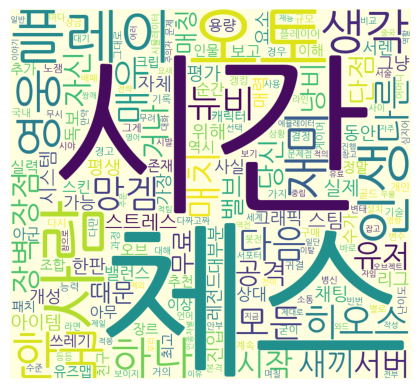

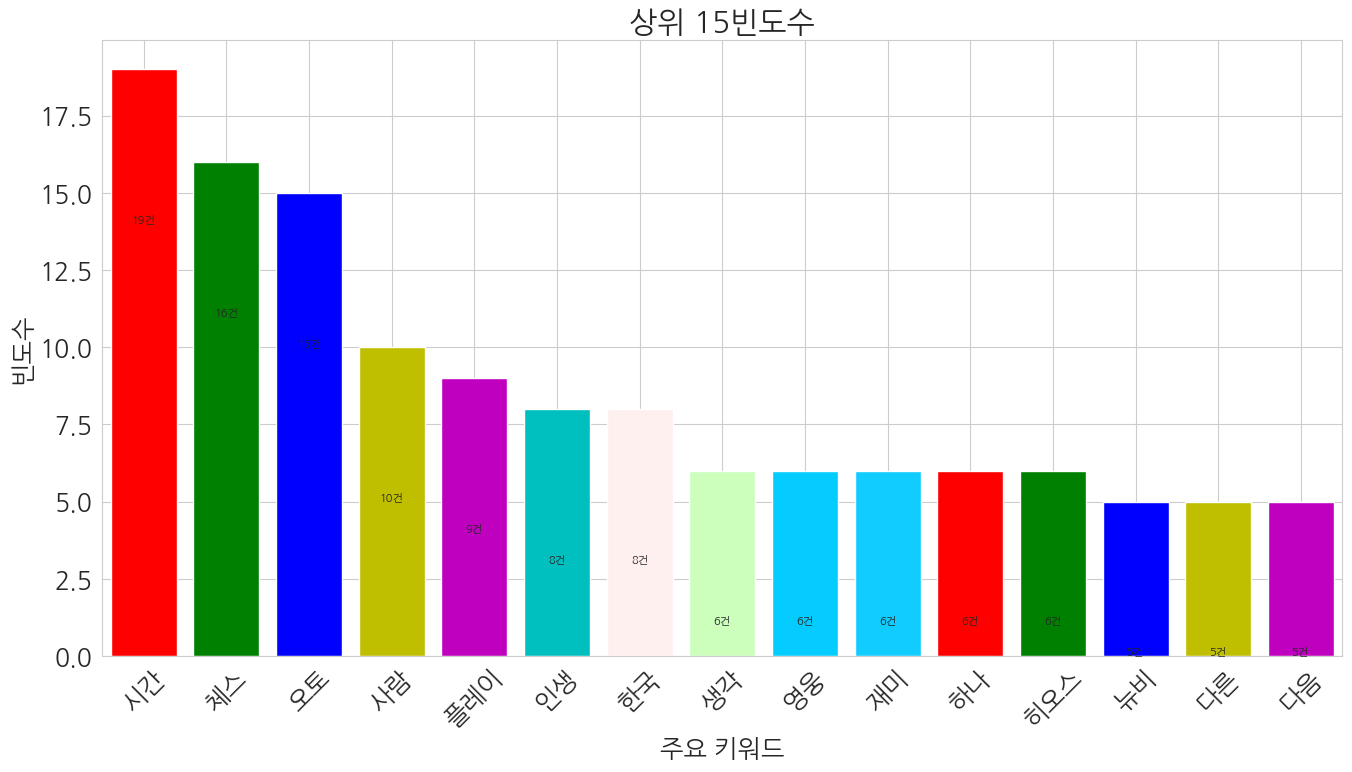

In [51]:
word_cloud("dota2",dota_word_count, "dota.png")

elden.jpeg
{'소울': 81, '시간': 59, '보스': 54, '다크': 47, '플레이': 43, '사람': 37, '생각': 37, '프롬': 35, '오픈월드': 34, '공략': 32, '추천': 31, '재미': 30, '그냥': 29, '하나': 27, '무기': 26, '스토리': 26, '가드': 25, '도전': 25, '정말': 25, '트리': 25, '느낌': 24, '엔딩': 24, '다른': 23, '진행': 23, '난이도': 22, '니아': 22, '말레': 22, '보고': 22, '최고': 22, '회차': 22, '모든': 21, '가장': 20, '단점': 20, '패턴': 20, '레벨': 19, '시리즈': 19, '입문': 19, '전투': 19, '지금': 19, '때문': 18, '마음': 18, '초반': 18, '공격': 17, '그래픽': 17, '요소': 17, '존나': 17, '개인': 16, '디자인': 16, '문제': 16, '새끼': 16, '시작': 16, '인생': 16, '전작': 16, '존재': 16, '탐험': 16, '해도': 16, '기트': 15, '평가': 15, '구매': 14, '모험': 14, '부분': 14, '시스템': 14, '씨발': 14, '최적화': 14, '또한': 13, '매우': 13, '방법': 13, '방식': 13, '시발': 13, '이크': 13, '장점': 13, '켈라': 13, '경우': 12, '기존': 12, '너머': 12, '바로': 12, '이상': 12, '자유도': 12, '전회': 12, '클리어': 12, '계속': 11, '나무': 11, '다시': 11, '당신': 11, '던전': 11, '아이템': 11, '여러': 11, '유저': 11, '이건': 11, '이해': 11, '필요': 11, '가끔': 10, '기억': 10, '다음': 10, '마법': 10, '빌드': 10, '상황': 10, '선택':

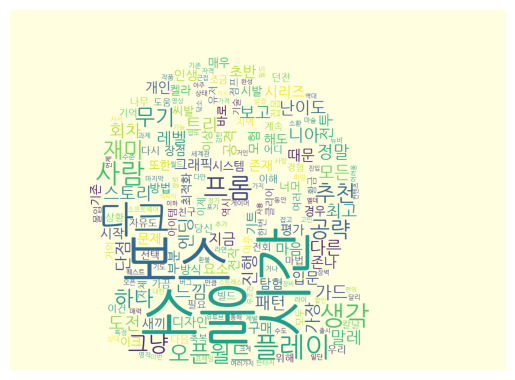

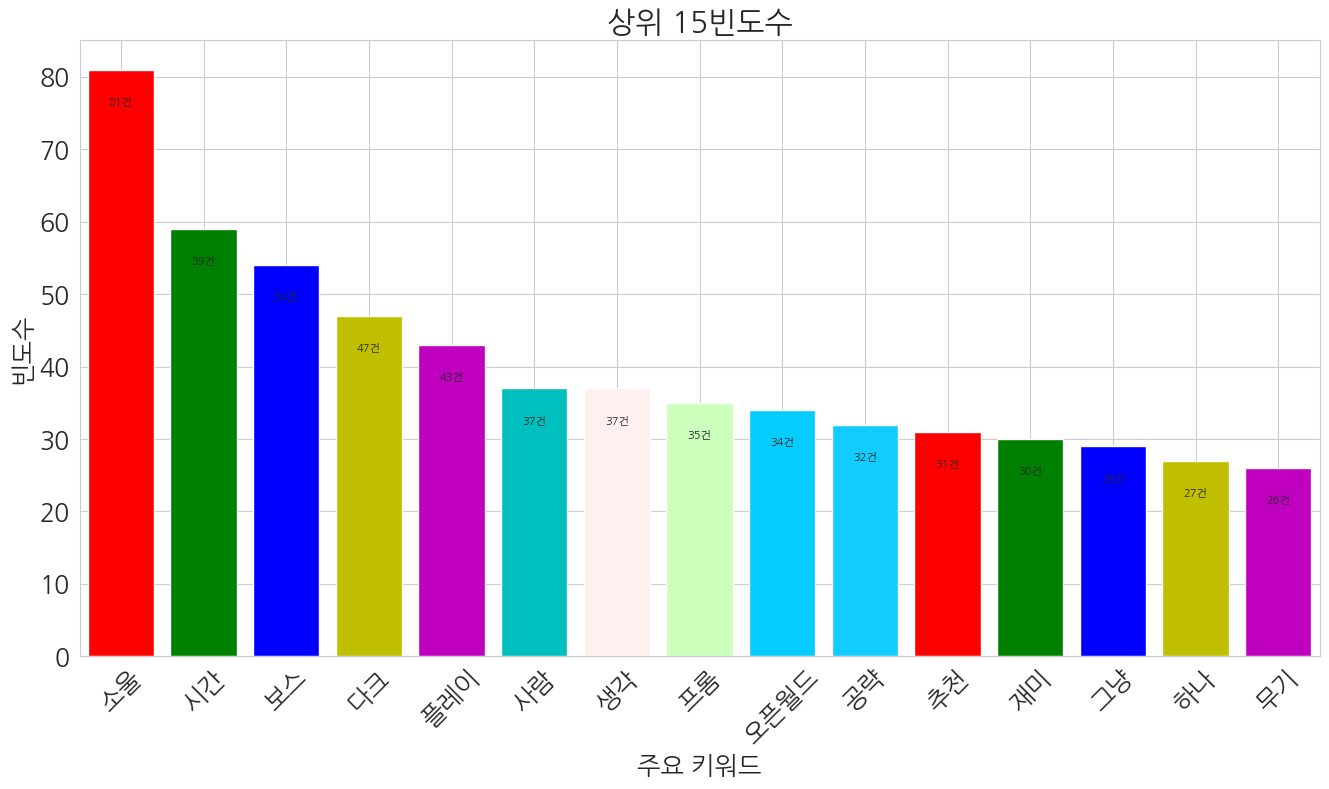

In [52]:
word_cloud("elden",elden_word_count, "elden.jpeg")

cs2.png
{'새끼': 20, '중국인': 20, '사람': 15, '중국': 15, '시작': 14, '존나': 14, '짱깨': 14, '병신': 12, '시발': 12, '유저': 12, '매칭': 11, '생각': 11, '정말': 11, '경쟁': 10, '그냥': 10, '다시': 10, '씨발': 10, '하나': 10, '스트라이크': 9, '시간': 9, '실력': 9, '재미': 9, '카운터': 9, '글로벌': 8, '때문': 8, '로란': 8, '매치': 8, '바로': 8, '역시': 8, '영어': 8, '최고': 8, '추천': 8, '친구': 8, '핵좀': 8, '뉴비': 7, '러시아': 7, '상대': 7, '세계': 7, '스킨': 7, '이제': 7, '플레이': 7, '한국인': 7, '근본': 6, '러시안': 6, '마이크': 6, '머리': 6, '발로란트': 6, '보고': 6, '시브': 6, '쓰레기': 6, '우리': 6, '이유': 6, '인물': 6, '조금': 6, '채팅': 6, '투표': 6, '팀킬': 6, '프라임': 6, '강퇴': 5, '구매': 5, '그래픽': 5, '나라': 5, '느낌': 5, '러시아인': 5, '망겜': 5, '무료': 5, '보이스': 5, '서든': 5, '서버': 5, '스팀': 5, '인생': 5, '일단': 5, '제발': 5, '중국어': 5, '추방': 5, '폭탄': 5, '해도': 5, '가장': 4, '갑자기': 4, '게브': 4, '국가': 4, '그것': 4, '기억': 4, '끼리': 4, '당신': 4, '덕분': 4, '모두': 4, '모드': 4, '문제': 4, '뭔가': 4, '발로': 4, '밸런스': 4, '별로': 4, '사실': 4, '상대방': 4, '수준': 4, '시스템': 4, '어디': 4, '언제': 4, '예전': 4, '자신': 4, '정통': 4, '쥬얼': 4, '지랄': 4, '짱개': 4, '차단'

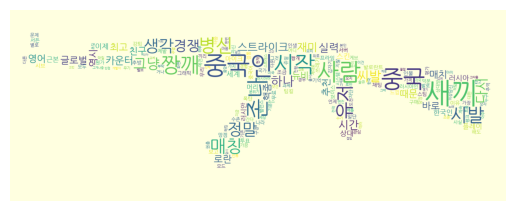

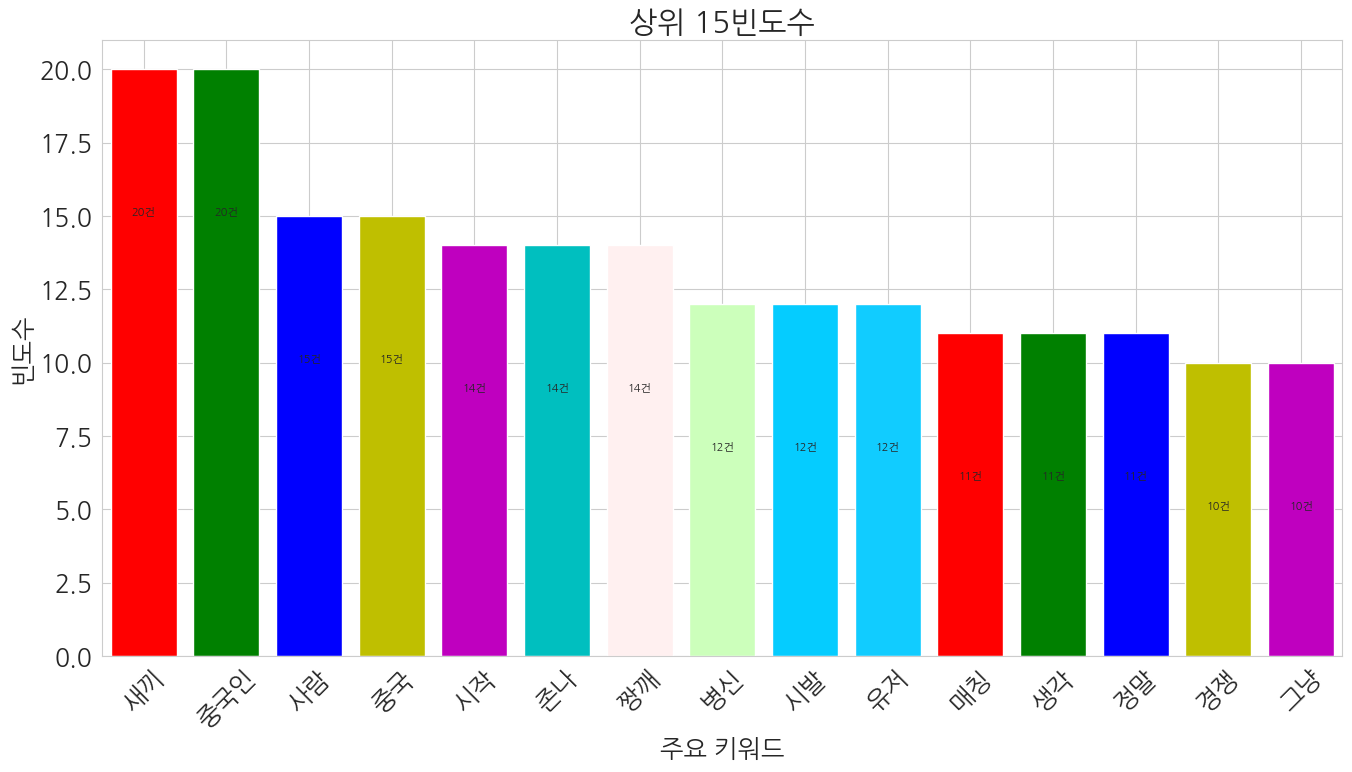

In [53]:
word_cloud("cs2",cs2_word_count, "cs2.png")

In [54]:
dota_word_dict = dict(dota_word_count)
elden_word_dict = dict(elden_word_count)
cs2_word_dict = dict(cs2_word_count)

In [55]:
dota_word_dict

{'롤': 22,
 '시간': 19,
 '체스': 16,
 '오토': 15,
 '수': 11,
 '것': 10,
 '사람': 10,
 '이': 10,
 '그': 9,
 '안': 9,
 '플레이': 9,
 '내': 8,
 '더': 8,
 '인생': 8,
 '한국': 8,
 '겜': 7,
 '년': 7,
 '돈': 7,
 '때': 7,
 '중': 7,
 '생각': 6,
 '영웅': 6,
 '재미': 6,
 '점': 6,
 '하나': 6,
 '히오스': 6,
 '뉴비': 5,
 '다른': 5,
 '다음': 5,
 '를': 5,
 '망겜': 5,
 '매우': 5,
 '매치': 5,
 '모든': 5,
 '분': 5,
 '새끼': 5,
 '서버': 5,
 '시작': 5,
 '욕': 5,
 '유저': 5,
 '일': 5,
 '자신': 5,
 '장벽': 5,
 '장점': 5,
 '팀': 5,
 '함': 5,
 '개': 4,
 '거나': 4,
 '공격': 4,
 '낭비': 4,
 '단점': 4,
 '당신': 4,
 '때문': 4,
 '말': 4,
 '매칭': 4,
 '명': 4,
 '모': 4,
 '무료': 4,
 '밸브': 4,
 '스트레스': 4,
 '스팀': 4,
 '시스템': 4,
 '실제': 4,
 '아이템': 4,
 '온': 4,
 '왜': 4,
 '요소': 4,
 '위': 4,
 '위해': 4,
 '자체': 4,
 '적': 4,
 '좆': 4,
 '진입': 4,
 '채팅': 4,
 '타': 4,
 '판': 4,
 '평가': 4,
 '평생': 4,
 '한판': 4,
 '가능': 3,
 '가장': 3,
 '개성': 3,
 '그냥': 3,
 '그래픽': 3,
 '놈': 3,
 '대부분': 3,
 '독보': 3,
 '동안': 3,
 '등': 3,
 '또': 3,
 '레전드': 3,
 '리그': 3,
 '매력': 3,
 '밸런스': 3,
 '보고': 3,
 '볼': 3,
 '사실': 3,
 '상대': 3,
 '서렌': 3,
 '수가': 3,
 '순간': 3,
 '스킨': 

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer

dota_tfidf_vectorizer = TfidfTransformer()
dota_tf_idf_vect = dota_tfidf_vectorizer.fit_transform(dota_bow_vect)

el_tfidf_vectorizer = TfidfTransformer()
el_tf_idf_vect = el_tfidf_vectorizer.fit_transform(elden_bow_vect)

cs_tfidf_vectorizer = TfidfTransformer()
cs_tf_idf_vect = cs_tfidf_vectorizer.fit_transform(cs2_bow_vect)

In [57]:
print(f"dota: {dota_tf_idf_vect.shape}")
print(f"elden: {el_tf_idf_vect.shape}")
print(f"cs2: {cs_tf_idf_vect.shape}")

dota: (125, 1117)
elden: (528, 2835)
cs2: (341, 1615)


In [58]:
print(f"dota: \n{dota_tf_idf_vect[0]}")
print(f"elden: \n{el_tf_idf_vect[0]}")
print(f"cs2: \n{cs_tf_idf_vect[0]}")

dota: 
  (0, 1099)	0.6089093436362243
  (0, 797)	0.5609052554721263
  (0, 763)	0.5609052554721263
elden: 
  (0, 2718)	0.47481124282277826
  (0, 2708)	0.5150360865818902
  (0, 1289)	0.4402568950453261
  (0, 1218)	0.5616635822025042
cs2: 
  (0, 361)	1.0


In [59]:
vect_dota.vocabulary_

{'회부': 1099,
 '적응': 797,
 '자': 763,
 '시간': 554,
 '일': 751,
 '후회': 1108,
 '놈': 167,
 '정신': 824,
 '평생': 1015,
 '거나': 34,
 '해': 1069,
 '롤': 284,
 '어머니': 615,
 '무료': 349,
 '겜': 50,
 '보보': 416,
 '탕': 964,
 '모': 336,
 '개': 23,
 '쓰레기': 580,
 '셈': 513,
 '유기': 697,
 '에이': 628,
 '매치': 322,
 '중': 857,
 '개또': 25,
 '라이': 264,
 '병신': 411,
 '노잼': 164,
 '오토': 657,
 '체스': 911,
 '나': 140,
 '플레이': 1030,
 '적': 795,
 '클라이언트': 947,
 '안정화': 599,
 '방금': 384,
 '튕겨': 976,
 '분': 432,
 '검사': 45,
 '중이': 861,
 '탈주': 962,
 '동안': 238,
 '함': 1063,
 '짜증': 888,
 '예뮬': 648,
 '꽤': 134,
 '내면': 154,
 '패': 1000,
 '드립': 244,
 '난무': 147,
 '훨배': 1109,
 '나은': 146,
 '것': 46,
 '튕기': 977,
 '문제점': 360,
 '그': 100,
 '점': 813,
 '씨발': 582,
 '좆': 845,
 '망겜': 313,
 '당신': 204,
 '만약': 307,
 '이건': 715,
 '게': 47,
 '이브': 722,
 '뉴웰': 174,
 '역작': 634,
 '애': 604,
 '리스': 289,
 '미팅': 368,
 '시뮬레이터': 557,
 '테': 969,
 '이유': 730,
 '아이템': 592,
 '부족': 429,
 '캐릭터': 939,
 '관리': 78,
 '해킹': 1075,
 '범': 398,
 '영구': 641,
 '얘기': 613,
 '장점': 784,
 '단점': 197,
 '팀

In [60]:
vect_dota.vocabulary_

{'회부': 1099,
 '적응': 797,
 '자': 763,
 '시간': 554,
 '일': 751,
 '후회': 1108,
 '놈': 167,
 '정신': 824,
 '평생': 1015,
 '거나': 34,
 '해': 1069,
 '롤': 284,
 '어머니': 615,
 '무료': 349,
 '겜': 50,
 '보보': 416,
 '탕': 964,
 '모': 336,
 '개': 23,
 '쓰레기': 580,
 '셈': 513,
 '유기': 697,
 '에이': 628,
 '매치': 322,
 '중': 857,
 '개또': 25,
 '라이': 264,
 '병신': 411,
 '노잼': 164,
 '오토': 657,
 '체스': 911,
 '나': 140,
 '플레이': 1030,
 '적': 795,
 '클라이언트': 947,
 '안정화': 599,
 '방금': 384,
 '튕겨': 976,
 '분': 432,
 '검사': 45,
 '중이': 861,
 '탈주': 962,
 '동안': 238,
 '함': 1063,
 '짜증': 888,
 '예뮬': 648,
 '꽤': 134,
 '내면': 154,
 '패': 1000,
 '드립': 244,
 '난무': 147,
 '훨배': 1109,
 '나은': 146,
 '것': 46,
 '튕기': 977,
 '문제점': 360,
 '그': 100,
 '점': 813,
 '씨발': 582,
 '좆': 845,
 '망겜': 313,
 '당신': 204,
 '만약': 307,
 '이건': 715,
 '게': 47,
 '이브': 722,
 '뉴웰': 174,
 '역작': 634,
 '애': 604,
 '리스': 289,
 '미팅': 368,
 '시뮬레이터': 557,
 '테': 969,
 '이유': 730,
 '아이템': 592,
 '부족': 429,
 '캐릭터': 939,
 '관리': 78,
 '해킹': 1075,
 '범': 398,
 '영구': 641,
 '얘기': 613,
 '장점': 784,
 '단점': 197,
 '팀

In [61]:
dota_invert_index_vectorizer = {v: k for k, v in vect_dota.vocabulary_.items()}
print("dota: "+str(dota_invert_index_vectorizer)[:100]+'...')

el_invert_index_vectorizer = {v: k for k, v in vect_el.vocabulary_.items()}
print("elden: "+str(el_invert_index_vectorizer)[:100]+'...')

cs2_invert_index_vectorizer = {v: k for k, v in vect_cs2.vocabulary_.items()}
print("cs2: "+str(cs2_invert_index_vectorizer)[:100]+'...')

dota: {1099: '회부', 797: '적응', 763: '자', 554: '시간', 751: '일', 1108: '후회', 167: '놈', 824: '정신', 1015: '평생', ...
elden: {1289: '새끼', 1218: '사', 2708: '할인', 2718: '해', 1234: '사랑', 124: '것', 274: '그', 2549: '트루', 2487: '킹'...
cs2: {361: '뜻', 120: '군대', 689: '사이', 1302: '짜장', 719: '새끼', 210: '내', 822: '시간', 507: '무', 552: '발', 125...


In [62]:
from sklearn.model_selection import train_test_split

def testandtrain(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)
    return {"x_train":x_train, "x_test":x_test, "y_train":y_train, "y_test":y_test}

In [63]:
dota_case = testandtrain(dota_tf_idf_vect, dodrop['label'])
elden_case = testandtrain(el_tf_idf_vect, eldrop['label'])
cs2_case = testandtrain(cs_tf_idf_vect, cadrop['label'])


In [64]:
print(f"dota_case: {dota_case['x_train'].shape}, {dota_case['y_train'].shape}, {dota_case['x_test'].shape}")
print(f"elden_case: {elden_case['x_train'].shape}, {elden_case['y_train'].shape}")
print(f"cs2_case: {cs2_case['x_train'].shape}, {cs2_case['y_train'].shape}")


dota_case: (87, 1117), (87,), (38, 1117)
elden_case: (369, 2835), (369,)
cs2_case: (238, 1615), (238,)


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def lrstart(case):
    lr = LogisticRegression(random_state = 0)
    lr.fit(case["x_train"], case["y_train"])
    
    y_pred = lr.predict(case["x_test"])
    print(case["x_train"].shape)
    print('accuracy: %.2f' % accuracy_score(case["y_test"], y_pred))
    print('precision: %.2f' % precision_score(case["y_test"], y_pred))
    print('recall: %.2f' % recall_score(case["y_test"], y_pred))
    print('F1: %.2f' % f1_score(case["y_test"], y_pred))
    return y_pred, lr

In [66]:
print("dota: ")
dota_pred, lr = lrstart(dota_case)
print("-"*20)

print("elden: ")
elden_pred, lr = lrstart(elden_case)
print("-"*20)

print("cs2: ")
cs2_pred, lr = lrstart(cs2_case)
print("-"*20)


dota: 
(87, 1117)
accuracy: 0.82
precision: 0.88
recall: 0.74
F1: 0.80
--------------------
elden: 
(369, 2835)
accuracy: 0.76
precision: 0.76
recall: 0.97
F1: 0.85
--------------------
cs2: 
(238, 1615)
accuracy: 0.70
precision: 0.77
recall: 0.40
F1: 0.52
--------------------


(38,) (38,)


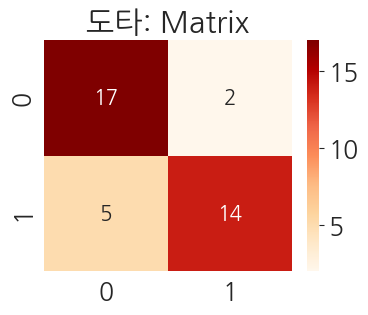

(159,) (159,)


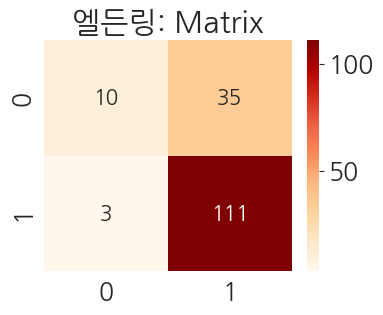

(103,) (103,)


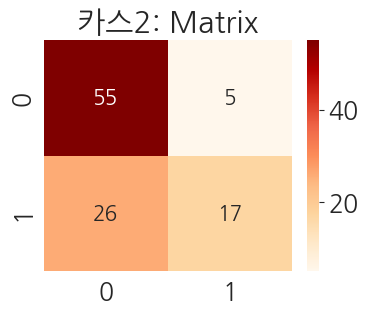

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def pltshow(name, case, y_pred):
    print(case['y_test'].shape, y_pred.shape)
    confu = confusion_matrix(y_true = case["y_test"], y_pred = y_pred)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
    plt.title(f'{name}: Matrix')
    plt.show()
pltshow("도타", dota_case, dota_pred)
pltshow("엘든링", elden_case, elden_pred)
pltshow("카스2", cs2_case, cs2_pred)

In [ ]:
col = ['review', 'label']
dodrop_df = dodrop[col]
cadrop_df = cadrop[col]
eldrop_df = eldrop[col]
concat_df = pd.concat([dodrop_df, cadrop_df, eldrop_df], axis=0)

In [113]:
concat_df

,review,label
0,사회부적응자들이나 하는게임,0.0
1,시간 다른일 했으면 어땠을까요 후회뿐이네요,0.0
2,게임은 비추 누르고 시간하는 네놈들도 제정신은 아니야,0.0
3,평생 이거나 해,1.0
4,롤의 어머니,1.0
...,...,...
550,당신은 새로운 이세계에 왔습니다 이제 이쁜 들이 당신주위를 둘러싸 용사님 세계를 ...,1.0
551,알겠는가 미켈라의 칼날 말레니아를 알겠는가 미켈라의 칼날 말레니아를 알겠는가 ...,1.0
552,말라리아 모기 씹새끼야 제발 피흡하지말고 돌진하지말고 뒤져라 씨발,0.0
553,확실히 엘든링을 사고 나서 내 인생이 달라졌다 원래는 고딩때 일진 눈도 못마주치고 ...,1.0


In [224]:

def no_label_data_result(df):
    df['review'] = df['review'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
    df['review'] = df['review'].apply(lambda x: None if len(str(x).strip())<=1 else x )
    #concat_df.drop(columns='Column1', inplace=True)
    df.drop(index=df[df['review'].isnull()==True].index,inplace=True)

    vect = CountVectorizer(tokenizer = lambda x: frequency_text_Bow(x))
    bow_vect = vect.fit_transform(df['review'].tolist())
    word_list = vect.get_feature_names_out()
    count_list = bow_vect.toarray().sum(axis=0)

    word_count = sorted_word_count(word_list, count_list)
    word_cloud("no_label_data", word_count, "elden.jpeg")

    word_dict = dict(word_count)
    tfidf_vectorizer = TfidfTransformer()
    tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

    print(f"no_label_data: {tf_idf_vect.shape}")
    print(f"no_label_data: \n{tf_idf_vect[0]}")

    invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
    print("dota: "+str(invert_index_vectorizer)[:100]+'...')
    case = testandtrain(tf_idf_vect, concat_df['label'])
    print(f"case: {case['x_train'].shape}, {case['y_train'].shape}")
    y_pred, lr = lrstart(case)
    pltshow("집합", case, y_pred)
    return case, tf_idf_vect, tfidf_vectorizer, vect



/Users/min/anaconda3/envs/BigDataStu/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


elden.jpeg
{'시간': 87, '소울': 80, '사람': 62, '플레이': 59, '보스': 54, '생각': 54, '다크': 47, '재미': 45, '하나': 43, '그냥': 41, '새끼': 41, '추천': 41, '정말': 39, '시작': 35, '프롬': 35, '오픈월드': 34, '최고': 33, '공략': 32, '다른': 31, '존나': 31, '때문': 30, '보고': 30, '느낌': 29, '무기': 29, '도전': 28, '모든': 28, '유저': 28, '인생': 28, '진행': 28, '가장': 27, '시발': 27, '단점': 26, '스토리': 26, '가드': 25, '그래픽': 25, '난이도': 25, '씨발': 25, '트리': 25, '엔딩': 24, '지금': 24, '다시': 23, '평가': 23, '해도': 23, '마음': 22, '문제': 22, '바로': 22, '시스템': 22, '회차': 22, '공격': 21, '구매': 21, '니아': 21, '말레': 21, '시리즈': 21, '역시': 21, '요소': 21, '전투': 21, '중국인': 21, '친구': 21, '뉴비': 20, '입문': 20, '장점': 20, '존재': 20, '패턴': 20, '당신': 19, '레벨': 19, '매우': 19, '전작': 19, '초반': 19, '개인': 18, '다음': 18, '우리': 18, '이상': 18, '이제': 18, '중국': 18, '경우': 17, '상대': 17, '실력': 17, '조금': 17, '체스': 17, '계속': 16, '기존': 16, '디자인': 16, '또한': 16, '매칭': 16, '방법': 16, '병신': 16, '서버': 16, '아이템': 16, '오토': 16, '이해': 16, '자체': 16, '짱깨': 16, '탐험': 16, '거나': 15, '기트': 15, '방식': 15, '세계': 15, '어디': 1

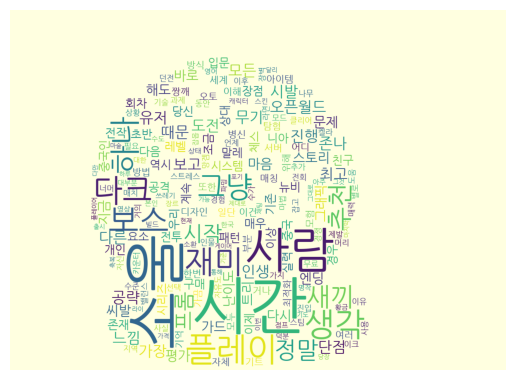

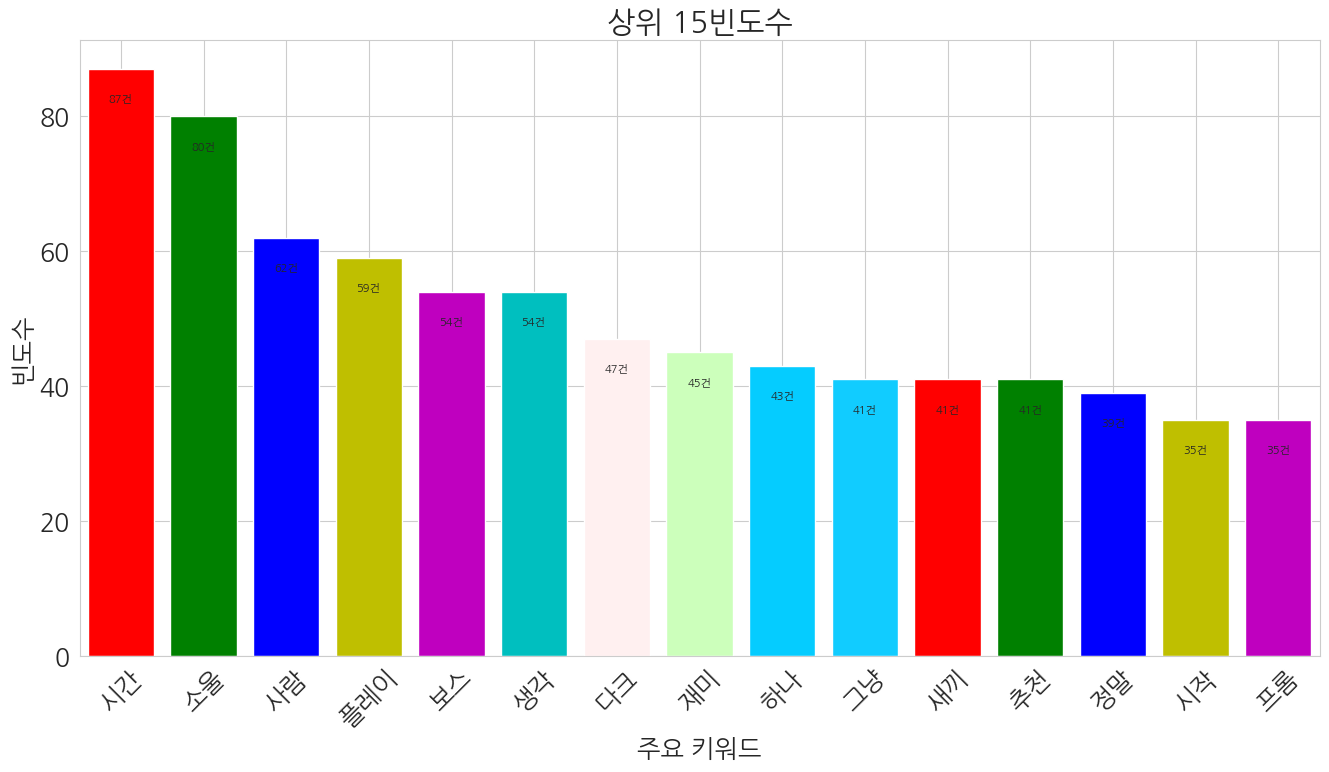

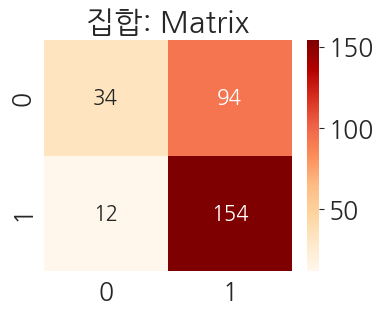

(980, 4085)


In [225]:
case, tf_idf_vect, tfidf_vectorizer, vect = no_label_data_result(concat_df)
print(tf_idf_vect.shape)

In [226]:
print(tf_idf_vect.shape)
concat_df['label'].shape

(980, 4085)


(980,)

In [227]:
concat_df['label'].value_counts()


label
1.0    573
0.0    407
Name: count, dtype: int64

In [164]:
positive_random_idx = concat_df[concat_df['label']==1.0].sample(407, random_state=12).index.tolist()
negative_random_idx = concat_df[concat_df['label']==0.0].sample(407, random_state=12).index.tolist()
random_idx = positive_random_idx + negative_random_idx
x = tf_idf_vect[random_idx]
y = concat_df['label'][random_idx]

print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
y_pred = lr2.predict(x_test)


(814, 4085) (1708,)


ValueError: Found input variables with inconsistent numbers of samples: [814, 1708]

(814, 4085) (814,)


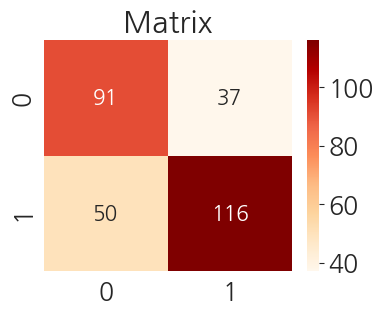

In [228]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
trainX_over, trainY_over = smote.fit_resample(case["x_train"],case["y_train"])
lr2 = LogisticRegression(random_state = 0)
lr2.fit(trainX_over, trainY_over)
y_pred = lr2.predict(case['x_test'])
print(trainX_over.shape, trainY_over.shape)
from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = case["y_test"], y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Matrix')
plt.show()

In [232]:
#test
review_input = input()
review = vect.transform([review_input])
tf_idf_vect = tfidf_vectorizer.fit_transform(review)
y_pred = lr2.predict(tf_idf_vect)
print(f'사용자가 입력한 리뷰 "{review_input}"의 예측결과: {y_pred[0]}')


사용자가 입력한 리뷰 "그래도 가끔 이상한거 빼면 전체적으로 스토리가 괜찮아요"의 예측결과: 1.0
